# Learning to Solve Large-Scale Security-Constrained Unit Commitment Problems
Alinson S. Xavier, Feng Qiu, Shabbir Ahmed

Security-Constrained Unit Commitment (SCUC) is a fundamental problem in power systems and electricity markets. In practical settings, SCUC is repeatedly solved via Mixed-Integer Linear Programming, sometimes multiple times per day, with only minor changes in input data. In this work, we propose a number of machine learning (ML) techniques to effectively extract information from previously solved instances in order to significantly improve the computational performance of MIP solvers when solving similar instances in the future. Based on statistical data, we predict redundant constraints in the formulation, good initial feasible solutions and affine subspaces where the optimal solution is likely to lie, leading to significant reduction in problem size. Computational results on a diverse set of realistic and large-scale instances show that, using the proposed techniques, SCUC can be solved on average 12 times faster than conventional methods, with no negative impact on solution quality.

[ArXiv](https://arxiv.org/abs/1902.01697)

# Summary of complex power, impedance, and admittance

<table><tr><th> symbol </th><th> Name </th><th>Complex representation</th></tr>
    <tr><td>$Y$ </td><td> admittance  (inverse impedance) </td><td>  $Y =  G + jB$ </td></tr>
<tr><td>$B$  </td><td> susceptance  </td><td>   </td></tr>
<tr><td>$G$  </td><td>s conductance (real part of admittance) </td><td> </td></tr>
<tr><td>$Z$  </td><td> impedance  </td><td> $Z = R + jX$ </td></tr>
<tr><td>$X$  </td><td>Reactance </td><td>   </td></tr>
<tr><td>$R$  </td><td> Resistance  </td><td>  </td></tr>
<tr><td>$S$  </td><td> Real powerflow approximation from bus 1 to bus 2 in a DC model  </td><td> $S=\frac{\theta_1 - \theta_2}{-{BR}_X}$ </td></tr>
<tr><td>$S$  </td><td> Real powerflow approximation constraint  </td><td>$|S| \leq \text{Rate}_A$ </td></tr>
</table>


## Manipulating a small case

None

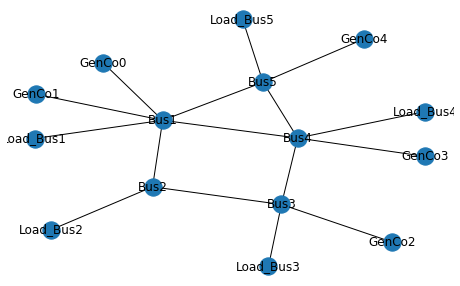

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import psst,os
from psst.case import read_matpower
from psst.model import build_model
from psst.network import create_network
casedir = 'matpower/data'
case5 = read_matpower(os.path.join(casedir,'case5.m'))
generator_df = pd.merge(case5.gen, case5.gencost, left_index=True, right_index=True)
network5 = create_network( case5, prog='neato')
display(network5.draw())
plt.savefig('case5.png')

In [14]:
case5.bus

TYPE   PD      QD  GS  BS  AREA  VM  VA  BASEKV  ZONE  VMAX  VMIN
Bus1     2    0    0.00   0   0     1   1   0     230     1   1.1   0.9
Bus2     1  300   98.61   0   0     1   1   0     230     1   1.1   0.9
Bus3     2  300   98.61   0   0     1   1   0     230     1   1.1   0.9
Bus4     3  400  131.47   0   0     1   1   0     230     1   1.1   0.9
Bus5     2    0    0.00   0   0     1   1   0     230     1   1.1   0.9

In [15]:
case5.branch

F_BUS T_BUS     BR_R    BR_X     BR_B  RATE_A  RATE_B  RATE_C  TAP  SHIFT  \
0  Bus1  Bus2  0.00281  0.0281  0.00712     400     400     400    0      0   
1  Bus1  Bus4  0.00304  0.0304  0.00658       0       0       0    0      0   
2  Bus1  Bus5  0.00064  0.0064  0.03126       0       0       0    0      0   
3  Bus2  Bus3  0.00108  0.0108  0.01852       0       0       0    0      0   
4  Bus3  Bus4  0.00297  0.0297  0.00674       0       0       0    0      0   
5  Bus4  Bus5  0.00297  0.0297  0.00674     240     240     240    0      0   

   BR_STATUS  ANGMIN  ANGMAX  
0          1    -360     360  
1          1    -360     360  
2          1    -360     360  
3          1    -360     360  
4          1    -360     360  
5          1    -360     360

In [18]:
case5.gen

GEN_BUS      PG  QG   QMAX   QMIN  VG  MBASE  GEN_STATUS  PMAX  PMIN  \
GenCo0    Bus1   40.00   0   30.0  -30.0   1    100           1    40     0   
GenCo1    Bus1  170.00   0  127.5 -127.5   1    100           1   170     0   
GenCo2    Bus3  323.49   0  390.0 -390.0   1    100           1   520     0   
GenCo3    Bus4    0.00   0  150.0 -150.0   1    100           1   200     0   
GenCo4    Bus5  466.51   0  450.0 -450.0   1    100           1   600     0   

        PC1  PC2  QC1MIN  QC1MAX  QC2MIN  QC2MAX  RAMP_AGC  RAMP_10  RAMP_30  \
GenCo0    0    0       0       0       0       0         0       40        0   
GenCo1    0    0       0       0       0       0         0      170        0   
GenCo2    0    0       0       0       0       0         0      520        0   
GenCo3    0    0       0       0       0       0         0      200        0   
GenCo4    0    0       0       0       0       0         0      600        0   

        RAMP_Q  APF  STARTUP_RAMP  SHUTDOWN_RAMP  MINIMUM_UP_TIME  \
GenCo0       0    0            40             40                0   
GenCo1       0    0           170            170                0   
GenCo2       0    0           520            520                0   
GenCo3       0    0           200            200                0   
GenCo4       0    0           600            600                0   

        MINIMUM_DOWN_TIME  
GenCo0                  0  
GenCo1                  0  
GenCo2                  0  
GenCo3                  0  
GenCo4                  0

In [16]:
case5.load

Bus1   Bus2   Bus3   Bus4  Bus5
0   0.0  300.0  300.0  400.0   0.0

In [2]:
!. ~/.bash_profile && pyomo help --solvers


Pyomo Solvers and Solver Managers
---------------------------------
Pyomo uses 'solver managers' to execute 'solvers' that perform
optimization and other forms of model analysis.  A solver directly
executes an optimizer, typically using an executable found on the
user's PATH environment.  Solver managers support a flexible mechanism
for asyncronously executing solvers either locally or remotely.  The
following solver managers are available in Pyomo:

    neos       Asynchronously execute solvers on the NEOS server
    serial     Synchronously execute solvers locally

If no solver manager is specified, Pyomo uses the serial solver
manager to execute solvers locally.  The pyro and phpyro solver
managers require the installation and configuration of the pyro
software.  The neos solver manager is used to execute solvers on the
NEOS optimization server.


Serial Solver Interfaces
------------------------
The serial, pyro and phpyro solver managers support the following
solver interfaces:



In [2]:
import sys
#sys.path.append('/Users/zuck016/Projects/Proposals/DataModelConvergence_2019/scipoptsuite-6.0.2/scip/interfaces/ampl/build')
try:
    model5 = build_model(case5, generator_df)
    model5.solve(solver='scip', verbose=True)
except ValueError as e:
    print(e)
    
model5.results.power_generated

Changed model.MinimumPowerOutput to use within=Reals
    2019/Matpower_instances/scip.set' exists in the current working directory,
    but SCIP options are being set using a separate options file. The options
    file '/Users/zuck016/Projects/Proposals/DataModelConvergence_2019/Matpower
    _instances/scip.set' will be ignored.


SCIP version 6.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 4.0.2] [GitHash: e639a0059d]
Copyright (C) 2002-2019 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline EditLine w  GNU library for command line editing (gnu.org/s/readline)
  SoPlex 4.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: b8833cd3]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.3.8          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  ASL                  AMPL Solver Library developed by D. Gay (www.netlib.com/ampl)


number of parameters = 2430
non-default parameter settings:


read pro

GenCo4      GenCo2  GenCo0  GenCo1  GenCo3
0  466.505154  323.494846    40.0   170.0     0.0

# Case 7 (with timepoints)

None

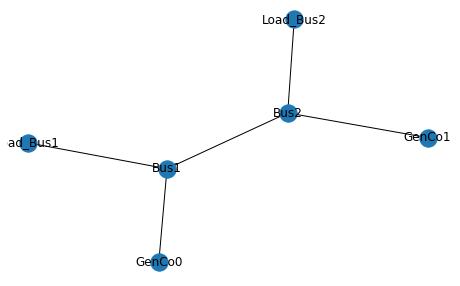

In [4]:
casedir = '../PSST/psst/docs/notebooks/cases'
case7 = read_matpower(os.path.join(casedir,'case7.m'))
generator_df = pd.merge(case7.gen, case7.gencost, left_index=True, right_index=True)
case7.load = pd.read_csv(os.path.join(casedir,'case7.csv'), index_col=0)
network7 = create_network( case7, prog='neato')
display(network7.draw())
plt.savefig('case7.png')

In [7]:
case7.load

Bus1   Bus2
0    0.0  100.0
1    0.0  100.0
2    0.0  100.0
3    0.0  120.0
4    0.0  120.0
5    0.0  120.0
6    0.0  150.0
7    0.0  150.0
8    0.0  150.0
9    0.0  200.0
10   0.0  200.0
11   0.0  200.0
12   0.0  300.0
13   0.0  400.0
14   0.0  300.0
15   0.0  200.0
16   0.0  200.0
17   0.0  200.0
18   0.0  150.0
19   0.0  150.0
20   0.0  150.0
21   0.0  150.0
22   0.0  100.0
23   0.0  100.0

In [8]:
from IPython.display import HTML
HTML(generator_df[['PMIN','PMAX']].to_html().replace('\n',''))

In [6]:
model7 = build_model(case7)
model7.solve(solver='scip', verbose=True)
model7.results.unit_commitment

Changed model.MinimumPowerOutput to use within=Reals


SCIP version 6.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 4.0.2] [GitHash: e639a0059d]
Copyright (C) 2002-2019 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline EditLine w  GNU library for command line editing (gnu.org/s/readline)
  SoPlex 4.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: b8833cd3]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.3.8          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  ASL                  AMPL Solver Library developed by D. Gay (www.netlib.com/ampl)


number of parameters = 2430
non-default parameter settings:


read pro

/Users/zuck016/Projects/Proposals/DataModelConvergence_2019/PSST/psst/psst/solver/results.py:42: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead
  return df.clip_lower(0)


GenCo0  GenCo1
0      1.0     0.0
1      1.0     0.0
2      1.0     0.0
3      1.0     0.0
4      1.0     0.0
5      1.0     0.0
6      1.0     0.0
7      1.0     0.0
8      1.0     0.0
9      1.0     0.0
10     1.0     0.0
11     1.0     0.0
12     1.0     1.0
13     1.0     1.0
14     1.0     1.0
15     1.0     0.0
16     1.0     0.0
17     1.0     0.0
18     1.0     0.0
19     1.0     0.0
20     1.0     0.0
21     1.0     0.0
22     1.0     0.0
23     1.0     0.0

## Which Matpower cases are readable?  Which are convertable to a UC model?

In [5]:
import psst
from psst.case import read_matpower
from psst.network import create_network
import pandas as pd

cases = """case1888rte
case1951rte
case2848rte
case3012wp
case3375wp
case6468rte
case6470rte
case6495rte
case6515rte""".split('\n')

from IPython.display import display, Markdown
matpower = {}
scuc = {}
network = {}

In [2]:

import psst, os
from psst.case import read_matpower
from psst.model import build_model
casedir = 'matpower/data'
generator = {}
for casefile in cases:
    #if casefile[-2:] == '.m':
        try:
            case = read_matpower(os.path.join(casedir, casefile + '.m'))
            generator[casefile] = pd.merge(case.gen, case.gencost, left_index=True, right_index=True)
            badgen = generator[ casefile][(generator[casefile]['PMIN'] < 0)]
            if len(badgen.index) > 0:
                print('\n`{}`\n'.format(casefile))
                #print(badgen.to_html().replace('\n',''))
                display(badgen)
        except TypeError as e:
            print('Could not parse {}'.format(casefile))


`case1888rte`



GEN_BUS   PG   QG  QMAX  QMIN     VG  MBASE  GEN_STATUS  PMAX  PMIN  \
GenCo32  Bus973  0.0  0.0   0.0   0.0  1.039    100           0   0.0  -8.0   

         PC1  PC2  QC1MIN  QC1MAX  QC2MIN  QC2MAX  RAMP_AGC  RAMP_10  RAMP_30  \
GenCo32    0    0       0       0       0       0         0      0.0        0   

         RAMP_Q  APF  STARTUP_RAMP  SHUTDOWN_RAMP  MINIMUM_UP_TIME  \
GenCo32       0    0           0.0            0.0                0   

         MINIMUM_DOWN_TIME  MODEL  STARTUP  SHUTDOWN  NCOST  COST_2  COST_1  \
GenCo32                  0      2        0         0      2       0       2   

         COST_0  
GenCo32       0


`case1951rte`



GEN_BUS    PG   QG  QMAX  QMIN     VG  MBASE  GEN_STATUS  PMAX  PMIN  \
GenCo35  Bus973 -7.47  0.0   0.0   0.0  1.121    100           1   0.0  -8.0   

         PC1  PC2  QC1MIN  QC1MAX  QC2MIN  QC2MAX  RAMP_AGC  RAMP_10  RAMP_30  \
GenCo35    0    0       0       0       0       0         0      0.0        0   

         RAMP_Q  APF  STARTUP_RAMP  SHUTDOWN_RAMP  MINIMUM_UP_TIME  \
GenCo35       0    0           0.0            0.0                0   

         MINIMUM_DOWN_TIME  MODEL  STARTUP  SHUTDOWN  NCOST  COST_2  COST_1  \
GenCo35                  0      2        0         0      2       0       1   

         COST_0  
GenCo35       0


`case2848rte`



GEN_BUS    PG   QG  QMAX  QMIN     VG  MBASE  GEN_STATUS  PMAX  \
GenCo191   Bus124 -5.91  0.0   0.0   0.0  1.047    100           1   0.0   
GenCo192   Bus124 -5.91  0.0   0.0   0.0  1.047    100           1   0.0   
GenCo314  Bus1276 -8.00  0.0   0.0   0.0  1.069    100           1   0.0   

          PMIN  PC1  PC2  QC1MIN  QC1MAX  QC2MIN  QC2MAX  RAMP_AGC  RAMP_10  \
GenCo191  -7.0    0    0       0       0       0       0         0      0.0   
GenCo192  -7.0    0    0       0       0       0       0         0      0.0   
GenCo314  -8.0    0    0       0       0       0       0         0      0.0   

          RAMP_30  RAMP_Q  APF  STARTUP_RAMP  SHUTDOWN_RAMP  MINIMUM_UP_TIME  \
GenCo191        0       0    0           0.0            0.0                0   
GenCo192        0       0    0           0.0            0.0                0   
GenCo314        0       0    0           0.0            0.0                0   

          MINIMUM_DOWN_TIME  MODEL  STARTUP  SHUTDOWN  NCOST  COST_2  COST_1  \
GenCo191                  0      2        0         0      2       0       1   
GenCo192                  0      2        0         0      2       0       1   
GenCo314                  0      2        0         0      2       0       1   

          COST_0  
GenCo191       0  
GenCo192       0  
GenCo314       0


`case3012wp`



GEN_BUS     PG     QG QMAX  QMIN       VG  MBASE  GEN_STATUS   PMAX  \
GenCo50    Bus152    0.0   0.00   72   -29  1.00000  150.0           0  135.0   
GenCo51    Bus152    0.0   0.00   72   -29  1.00000  150.0           0  135.0   
GenCo52    Bus153    0.0   0.00   72   -29  1.00000  150.0           0  135.0   
GenCo53    Bus153    0.0   0.00   72   -29  1.00000  150.0           0  135.0   
GenCo81    Bus240  179.0 -62.00  105   -62  1.02222  209.0           1  179.0   
GenCo82    Bus240  179.0 -62.00  105   -62  1.02222  209.0           1  179.0   
GenCo83    Bus240    0.0   0.00  160  -100  1.00000  209.0           0  179.0   
GenCo84    Bus241  179.0 -19.63  160  -100  1.02222  209.0           1  179.0   
GenCo192   Bus993    0.0   0.00   11     0  1.00000   24.5           0   31.0   
GenCo193   Bus993    0.0   0.00   10     0  1.00000   24.5           0   31.0   
GenCo312  Bus2222    0.0   0.00    8     0  1.00000   27.3           0   28.0   
GenCo313  Bus2222   29.0   8.00    8     0  1.06405   28.5           1   29.0   
GenCo314  Bus2222   28.0   8.00    8     0  1.06405   27.3           1   28.0   

           PMIN  PC1  PC2  QC1MIN  QC1MAX  QC2MIN  QC2MAX  RAMP_AGC  RAMP_10  \
GenCo50  -135.0    0    0       0       0       0       0         0    135.0   
GenCo51  -135.0    0    0       0       0       0       0         0    135.0   
GenCo52  -135.0    0    0       0       0       0       0         0    135.0   
GenCo53  -135.0    0    0       0       0       0       0         0    135.0   
GenCo81  -200.0    0    0       0       0       0       0         0    179.0   
GenCo82  -200.0    0    0       0       0       0       0         0    179.0   
GenCo83  -200.0    0    0       0       0       0       0         0    179.0   
GenCo84  -200.0    0    0       0       0       0       0         0    179.0   
GenCo192  -32.0    0    0       0       0       0       0         0     31.0   
GenCo193  -32.0    0    0       0       0       0       0         0     31.0   
GenCo312   -5.0    0    0       0       0       0       0         0     28.0   
GenCo313   -5.0    0    0       0       0       0       0         0     29.0   
GenCo314   -5.0    0    0       0       0       0       0         0     28.0   

          RAMP_30  RAMP_Q  APF  STARTUP_RAMP  SHUTDOWN_RAMP  MINIMUM_UP_TIME  \
GenCo50         0       0    0         135.0          135.0                0   
GenCo51         0       0    0         135.0          135.0                0   
GenCo52         0       0    0         135.0          135.0                0   
GenCo53         0       0    0         135.0          135.0                0   
GenCo81         0       0    0         179.0          179.0                0   
GenCo82         0       0    0         179.0          179.0                0   
GenCo83         0       0    0         179.0          179.0                0   
GenCo84         0       0    0         179.0          179.0                0   
GenCo192        0       0    0          31.0           31.0                0   
GenCo193        0       0    0          31.0           31.0                0   
GenCo312        0       0    0          28.0           28.0                0   
GenCo313        0       0    0          29.0           29.0                0   
GenCo314        0       0    0          28.0           28.0                0   

          MINIMUM_DOWN_TIME  MODEL  STARTUP  SHUTDOWN  NCOST  COST_2  COST_1  \
GenCo50                   0      2        0         0      2       0   137.4   
GenCo51                   0      2        0         0      2       0   137.4   
GenCo52                   0      2        0         0      2       0   137.4   
GenCo53                   0      2        0         0      2       0   137.4   
GenCo81                   0      2        0         0      2       0   137.4   
GenCo82                   0      2        0         0      2       0   137.4   
GenCo83                   0      2        0         0      2       0   13


`case3375wp`



GEN_BUS     PG    QG QMAX  QMIN       VG  MBASE  GEN_STATUS   PMAX  \
GenCo144   Bus152    0.0   0.0   72   -29  1.00000  150.0           0  135.0   
GenCo145   Bus152    0.0   0.0   72   -29  1.00000  150.0           0  135.0   
GenCo146   Bus153    0.0   0.0   72   -29  1.00000  150.0           0  135.0   
GenCo147   Bus153    0.0   0.0   72   -29  1.00000  150.0           0  135.0   
GenCo175   Bus240  179.0 -62.0  105   -62  1.02448  209.0           1  179.0   
GenCo176   Bus240  179.0 -62.0  105   -62  1.02448  209.0           1  179.0   
GenCo177   Bus240    0.0   0.0  160  -100  1.00000  209.0           0  179.0   
GenCo178   Bus241  179.0 -12.1  160  -100  1.02448  209.0           1  179.0   
GenCo286   Bus993    0.0   0.0   11     0  1.00000   24.5           0   31.0   
GenCo287   Bus993    0.0   0.0   10     0  1.00000   24.5           0   31.0   
GenCo406  Bus2222    0.0   0.0    8     0  1.00000   27.3           0   28.0   
GenCo407  Bus2222   29.0   8.0    8     0  1.06232   28.5           1   29.0   
GenCo408  Bus2222   28.0   8.0    8     0  1.06232   27.3           1   28.0   

           PMIN  PC1  PC2  QC1MIN  QC1MAX  QC2MIN  QC2MAX  RAMP_AGC  RAMP_10  \
GenCo144 -135.0    0    0       0       0       0       0         0    135.0   
GenCo145 -135.0    0    0       0       0       0       0         0    135.0   
GenCo146 -135.0    0    0       0       0       0       0         0    135.0   
GenCo147 -135.0    0    0       0       0       0       0         0    135.0   
GenCo175 -200.0    0    0       0       0       0       0         0    179.0   
GenCo176 -200.0    0    0       0       0       0       0         0    179.0   
GenCo177 -200.0    0    0       0       0       0       0         0    179.0   
GenCo178 -200.0    0    0       0       0       0       0         0    179.0   
GenCo286  -32.0    0    0       0       0       0       0         0     31.0   
GenCo287  -32.0    0    0       0       0       0       0         0     31.0   
GenCo406   -5.0    0    0       0       0       0       0         0     28.0   
GenCo407   -5.0    0    0       0       0       0       0         0     29.0   
GenCo408   -5.0    0    0       0       0       0       0         0     28.0   

          RAMP_30  RAMP_Q  APF  STARTUP_RAMP  SHUTDOWN_RAMP  MINIMUM_UP_TIME  \
GenCo144        0       0    0         135.0          135.0                0   
GenCo145        0       0    0         135.0          135.0                0   
GenCo146        0       0    0         135.0          135.0                0   
GenCo147        0       0    0         135.0          135.0                0   
GenCo175        0       0    0         179.0          179.0                0   
GenCo176        0       0    0         179.0          179.0                0   
GenCo177        0       0    0         179.0          179.0                0   
GenCo178        0       0    0         179.0          179.0                0   
GenCo286        0       0    0          31.0           31.0                0   
GenCo287        0       0    0          31.0           31.0                0   
GenCo406        0       0    0          28.0           28.0                0   
GenCo407        0       0    0          29.0           29.0                0   
GenCo408        0       0    0          28.0           28.0                0   

          MINIMUM_DOWN_TIME  MODEL  STARTUP  SHUTDOWN  NCOST  COST_2  COST_1  \
GenCo144                  0      2        0         0      2       0   137.4   
GenCo145                  0      2        0         0      2       0   137.4   
GenCo146                  0      2        0         0      2       0   137.4   
GenCo147                  0      2        0         0      2       0   137.4   
GenCo175                  0      2        0         0      2       0   137.4   
GenCo176                  0      2        0         0      2       0   137.4   
GenCo177                  0      2        0         0      2       0   137.4   
GenCo17


`case6468rte`



GEN_BUS     PG      QG    QMAX    QMIN     VG  MBASE  GEN_STATUS  \
GenCo67     Bus320   0.00    0.00    0.00    0.00  1.059    100           0   
GenCo68     Bus320   0.00    0.00    0.00    0.00  1.059    100           0   
GenCo126    Bus626   0.00   -8.30    8.30   -8.30  1.030    100           0   
GenCo165    Bus752   0.00   -2.63    3.00   -3.00  0.967    100           0   
GenCo237   Bus1113   0.00   -1.46   50.00  -40.00  1.077    100           0   
GenCo238   Bus1113   0.00   27.65   50.00  -40.00  1.077    100           0   
GenCo393   Bus2035  13.31    7.00    7.00   -7.00  1.065    100           1   
GenCo425   Bus2305   0.00    8.27   20.00  -20.00  1.032    100           0   
GenCo551   Bus2919   0.00    0.00    1.00    0.00  1.100    100           0   
GenCo552   Bus2919   0.00    0.00    1.00    0.00  1.100    100           0   
GenCo667   Bus3509   0.00    0.00    0.00    0.00  1.107    100           0   
GenCo695   Bus3624  -3.30    0.21   30.00  -10.00  1.021    100           1   
GenCo696   Bus3624  -3.30    0.21   28.00  -28.00  1.021    100           1   
GenCo907   Bus4850   0.00   -1.39   70.00  -80.00  1.121    100           0   
GenCo908   Bus4850   0.00   43.78   70.00  -80.00  1.121    100           0   
GenCo909   Bus4849   0.00   39.82   70.00  -80.00  1.150    100           0   
GenCo910   Bus4849   0.00   39.82   70.00  -80.00  1.150    100           0   
GenCo911   Bus4848   0.00   40.05   70.00  -80.00  1.150    100           0   
GenCo912   Bus4848   0.00   40.05   70.00  -80.00  1.150    100           0   
GenCo913   Bus4847   0.00   37.66   70.00  -80.00  1.147    100           0   
GenCo914   Bus4847   0.00   37.66   70.00  -80.00  1.147    100           0   
GenCo970   Bus5995   0.00   -3.15   60.00  -60.00  1.043    100           0   
GenCo971   Bus5996   0.00  -39.78   60.00  -60.00  1.091    100           0   
GenCo979   Bus6014   0.00   -3.52  100.00 -100.00  1.035    100           0   
GenCo980   Bus6014   0.00   -3.52  100.00 -100.00  1.035    100           0   
GenCo985   Bus6028   0.00    0.00    2.50    0.00  1.072    100           0   
GenCo986   Bus6028   0.00    0.00    2.50    0.00  1.072    100           0   
GenCo1007  Bus6058   0.00    5.58    7.00    0.00  1.057    100           0   
GenCo1014  Bus6080   0.00   -3.09    0.00   -3.09  1.063    100           0   
GenCo1028  Bus6124   0.00   -3.00    0.00   -3.00  1.035    100           0   
GenCo1029  Bus6123   0.00  -60.00    0.00  -60.00  1.038    100           0   
GenCo1030  Bus6123   0.00  -60.00    0.00  -60.00  1.038    100           0   
GenCo1031  Bus6126   0.00   19.35   23.10    0.00  1.063    100           0   
GenCo1032  Bus6125   0.00    4.62    8.93    0.00  1.051    100           0   
GenCo1035  Bus6137   0.00  -82.25    0.00  -82.25  1.031    100           0   
GenCo1036  Bus6144   0.00    6.27    7.50    0.00  1.040    100           0   
GenCo1038  Bus6144   0.00    6.27    7.50    0.00  1.040    100           0   
GenCo1041  Bus6146   0.00   62.21   65.00    0.00  1.044    100           0   
GenCo1042  Bus6148   0.00   53.80   57.97    0.00  1.062    100           0   
GenCo1045  Bus6163   0.00   -4.17    0.00   -4.17  1.029    100           0   
GenCo1048  Bus6165 -11.17    0.34  182.00 -252.00  1.044    100           1   
GenCo1049  Bus6165 -11.17    0.34  182.00 -252.00  1.044    100           1   
GenCo1050  Bus6165 -11.17    0.34  182.00 -252.00  1.044    100           1   
GenCo1051  Bus6165 -11.17    0.34  182.00 -252.00  1.044    100           1   
GenCo1058  Bus6188   0.00    2.90    5.71    0.00  1.040    100           0   
GenCo1059  Bus6188   0.00    2.90    5.71    0.00  1.040    100           0   
GenCo1064  Bus6196   0.00    3.22    5.40    0.00  1.057    100           0   
GenCo1065  Bus6196   0.00    3.22    5.40    0.00  1.057    100           0   
GenCo1067  Bus6204   0.00   -1.28    0.00   -1.28  1.004    100           0   
GenCo1072  Bus6215   0.00    4.16  200.00 -200.00  1.073    1


`case6470rte`



GEN_BUS      PG     QG    QMAX    QMIN     VG  MBASE  GEN_STATUS  \
GenCo67     Bus319    0.00   0.00    0.00    0.00  1.050    100           0   
GenCo68     Bus319    0.00   0.00    0.00    0.00  1.050    100           0   
GenCo126    Bus623   -2.11  -8.30    8.30   -8.30  1.049    100           1   
GenCo166    Bus750    0.00  -2.78    3.00   -3.00  0.975    100           0   
GenCo398   Bus2028   21.36   4.36    7.00   -7.00  1.058    100           1   
GenCo430   Bus2296    0.00   3.50   20.00  -20.00  1.029    100           0   
GenCo557   Bus2905    0.00   0.00    1.00    0.00  1.073    100           0   
GenCo558   Bus2905    0.00   0.00    1.00    0.00  1.073    100           0   
GenCo673   Bus3491    0.00   0.00    0.00    0.00  1.080    100           0   
GenCo701   Bus3606   12.67   8.14   30.00  -10.00  1.025    100           1   
GenCo702   Bus3606   12.67   8.14   28.00  -28.00  1.025    100           1   
GenCo886   Bus4671    6.63   0.10    1.18   -0.10  1.008    100           1   
GenCo976   Bus5965    0.00  -3.43   60.00  -60.00  1.071    100           0   
GenCo977   Bus5966    0.00 -17.08   60.00  -60.00  1.120    100           0   
GenCo980   Bus5969    0.00   0.00    0.84    0.00  1.066    100           0   
GenCo981   Bus5969    0.00   0.00    0.84    0.00  1.066    100           0   
GenCo985   Bus5984    0.00  10.25  100.00 -100.00  1.069    100           0   
GenCo986   Bus5984    0.00  10.25  100.00 -100.00  1.069    100           0   
GenCo991   Bus5998    0.00  85.83   90.00    0.00  1.109    100           0   
GenCo992   Bus5998    0.00  85.83   90.00    0.00  1.109    100           0   
GenCo1013  Bus6028    0.00   2.92    7.00    0.00  1.054    100           0   
GenCo1020  Bus6050    0.00   0.00    1.23    0.00  1.111    100           0   
GenCo1036  Bus6093    0.00  -0.50    0.00   -0.50  1.066    100           0   
GenCo1037  Bus6096    0.00  81.06   85.31    0.00  1.106    100           0   
GenCo1041  Bus6107    0.00  -9.71    0.00   -9.71  1.076    100           0   
GenCo1048  Bus6118    0.00  -1.37    0.00   -1.37  1.108    100           0   
GenCo1054  Bus6135    0.00   0.75  182.00 -252.00  1.105    100           0   
GenCo1055  Bus6135    0.00   0.75  182.00 -252.00  1.105    100           0   
GenCo1056  Bus6135    0.00   0.75  182.00 -252.00  1.105    100           0   
GenCo1057  Bus6135    0.00   0.75  182.00 -252.00  1.105    100           0   
GenCo1064  Bus6158    0.00  -7.27    0.00   -7.27  1.078    100           0   
GenCo1065  Bus6158    0.00  -7.27    0.00   -7.27  1.078    100           0   
GenCo1073  Bus6174    0.00  -1.45    0.00   -1.45  1.041    100           0   
GenCo1078  Bus6185    0.00  98.19  200.00 -200.00  1.090    100           0   
GenCo1081  Bus6190    0.00   6.10   10.84    0.00  1.101    100           0   
GenCo1084  Bus6195    0.00  45.36   49.86    0.00  1.121    100           0   
GenCo1085  Bus6195    0.00  45.36   49.86    0.00  1.121    100           0   
GenCo1086  Bus6195    0.00  45.36   49.86    0.00  1.121    100           0   
GenCo1089  Bus6197    0.00 -99.91    0.00  -99.91  1.104    100           0   
GenCo1096  Bus6219    0.00  43.08   47.55    0.00  1.100    100           0   
GenCo1106  Bus6230    0.00   0.00    0.48    0.00  1.065    100           0   
GenCo1107  Bus6230    0.00   0.00    0.48    0.00  1.065    100           0   
GenCo1224  Bus6369   23.03  13.27   20.13   -7.22  1.043    100           1   
GenCo1280  Bus6425   -1.97   9.78   18.02   -6.63  1.081    100           1   
GenCo1281  Bus6426   -1.97  12.93   18.02   -6.63  1.085    100           1   
GenCo1282  Bus6427   -1.97  12.93   18.02   -6.63  1.085    100           1   
GenCo1311  Bus6456  133.43  -0.84  114.06  -45.94  0.998    100           1   
GenCo1322  Bus6467   61.14   2.46   89.40  -50.60  0.925    100           1   
GenCo1323  Bus6468   61.14   2.46   89.40  -50.60  0.925    100           1   
GenCo1324  Bus6469   61.14   2.46   89.40  -50.60  0.925    1


`case6495rte`



GEN_BUS      PG      QG    QMAX    QMIN     VG  MBASE  GEN_STATUS  \
GenCo67     Bus317    0.00    0.00    0.00    0.00  1.064    100           0   
GenCo68     Bus317    0.00    0.00    0.00    0.00  1.064    100           0   
GenCo126    Bus624   -4.03   -8.30    8.30   -8.30  1.039    100           1   
GenCo166    Bus751    0.00   -0.18    3.00   -3.00  1.015    100           0   
GenCo397   Bus2022   19.35    4.07    7.00   -7.00  1.055    100           1   
GenCo429   Bus2290   -4.65    2.94   20.00  -20.00  1.014    100           1   
GenCo556   Bus2897    0.00    1.00    1.00    0.00  1.100    100           0   
GenCo557   Bus2897    0.00    1.00    1.00    0.00  1.100    100           0   
GenCo674   Bus3484    0.00    0.00    0.00    0.00  1.095    100           0   
GenCo699   Bus3597   10.80    1.43   30.00  -10.00  1.021    100           1   
GenCo700   Bus3597   10.80    1.43   28.00  -28.00  1.021    100           1   
GenCo920   Bus4820    0.00    0.12   70.00  -80.00  1.077    100           0   
GenCo921   Bus4820  139.07   12.21   70.00  -80.00  1.077    100           1   
GenCo922   Bus4817  134.15   15.35   70.00  -80.00  1.077    100           1   
GenCo923   Bus4817  135.14   15.35   70.00  -80.00  1.077    100           1   
GenCo982   Bus5954    0.00    3.15   60.00  -60.00  1.065    100           0   
GenCo983   Bus5955    0.00  -23.11   60.00  -60.00  1.129    100           0   
GenCo991   Bus5973    0.00   -1.08  100.00 -100.00  1.074    100           0   
GenCo992   Bus5973    0.00   -1.08  100.00 -100.00  1.074    100           0   
GenCo997   Bus5987    0.00   51.00   51.00    0.00  1.107    100           0   
GenCo998   Bus5987    0.00   51.00   51.00    0.00  1.107    100           0   
GenCo1019  Bus6017    0.00    7.00    7.00    0.00  1.069    100           0   
GenCo1040  Bus6083    0.00   49.99   50.00    0.00  1.075    100           0   
GenCo1047  Bus6096    0.00  -66.95    0.00  -66.95  1.062    100           0   
GenCo1053  Bus6105    0.00   64.80   65.00    0.00  1.071    100           0   
GenCo1056  Bus6120    0.00 -298.31  300.00 -300.00  1.069    100           0   
GenCo1060  Bus6124   -4.82    3.68  182.00 -252.00  1.094    100           1   
GenCo1061  Bus6124   -4.82    3.68  182.00 -252.00  1.094    100           1   
GenCo1062  Bus6124   -4.82    3.68  182.00 -252.00  1.094    100           1   
GenCo1063  Bus6124   -4.82    3.68  182.00 -252.00  1.094    100           1   
GenCo1070  Bus6147    0.00  -11.64    0.00  -11.64  1.068    100           0   
GenCo1071  Bus6147    0.00  -11.64    0.00  -11.64  1.068    100           0   
GenCo1079  Bus6163    0.00   -3.25    0.00   -3.25  1.033    100           0   
GenCo1084  Bus6174   79.21   88.47  200.00 -200.00  1.054    100           1   
GenCo1087  Bus6179    0.00   10.55   10.64    0.00  1.095    100           0   
GenCo1090  Bus6184    0.00   69.64   69.64    0.00  1.121    100           0   
GenCo1091  Bus6184    0.00   69.64   69.64    0.00  1.121    100           0   
GenCo1092  Bus6184    0.00   69.64   69.64    0.00  1.121    100           0   
GenCo1102  Bus6208    0.00   35.86   35.96    0.00  1.089    100           0   
GenCo1112  Bus6219    0.00   -2.45    0.00   -2.58  1.065    100           0   
GenCo1113  Bus6219    0.00   -2.45    0.00   -2.58  1.065    100           0   
GenCo1178  Bus6303  156.52  -53.19  109.25  -53.31  0.963    100           1   
GenCo1243  Bus6371   10.04    8.02   20.13   -7.22  1.037    100           1   
GenCo1277  Bus6405  160.71   12.41  195.60  -56.56  1.015    100           1   
GenCo1278  Bus6406  167.73   13.92  195.94  -56.26  1.015    100           1   
GenCo1279  Bus6407  164.71   12.95  195.94  -56.26  1.015    100           1   
GenCo1280  Bus6408  167.72   13.59  196.04  -56.17  1.015    100           1   
GenCo1316  Bus6444    0.00    6.12   18.02   -6.63  1.087    100           0   
GenCo1317  Bus6445    0.00   10.61   18.02   -6.63  1.094    100           0   
GenCo1318  


`case6515rte`



GEN_BUS      PG      QG    QMAX    QMIN     VG  MBASE  GEN_STATUS  \
GenCo67     Bus317    0.00    0.00    0.00    0.00  1.058    100           0   
GenCo68     Bus317    0.00    0.00    0.00    0.00  1.058    100           0   
GenCo126    Bus624   -4.11   -8.30    8.30   -8.30  1.047    100           1   
GenCo166    Bus756    0.00   -0.31    3.00   -3.00  1.020    100           0   
GenCo399   Bus2029   19.35    2.48    7.00   -7.00  1.041    100           1   
GenCo431   Bus2297    0.00    4.15   20.00  -20.00  1.015    100           0   
GenCo558   Bus2904    0.00    0.73    1.00    0.00  1.100    100           0   
GenCo559   Bus2904    0.00    0.73    1.00    0.00  1.100    100           0   
GenCo676   Bus3491    0.00    0.00    0.00    0.00  1.100    100           0   
GenCo701   Bus3604   11.31    3.66   30.00  -10.00  1.008    100           1   
GenCo702   Bus3604   11.31    3.66   28.00  -28.00  1.008    100           1   
GenCo922   Bus4830  121.50   17.31   70.00  -80.00  1.079    100           1   
GenCo923   Bus4830  123.44   17.31   70.00  -80.00  1.079    100           1   
GenCo924   Bus4829  122.55   24.14   70.00  -80.00  1.091    100           1   
GenCo925   Bus4829  121.58   24.14   70.00  -80.00  1.091    100           1   
GenCo926   Bus4826  121.58   22.20   70.00  -80.00  1.087    100           1   
GenCo927   Bus4826  126.43   22.20   70.00  -80.00  1.087    100           1   
GenCo928   Bus4825  124.49   23.68   70.00  -80.00  1.090    100           1   
GenCo929   Bus4825  125.46   23.68   70.00  -80.00  1.090    100           1   
GenCo988   Bus5964    0.00  -31.40   60.00  -60.00  1.063    100           0   
GenCo989   Bus5965    0.00  -24.96   60.00  -60.00  1.121    100           0   
GenCo992   Bus5968    0.00    0.69    0.89    0.00  1.067    100           0   
GenCo993   Bus5968    0.00    0.69    0.89    0.00  1.067    100           0   
GenCo997   Bus5983    0.00   -3.03  100.00 -100.00  1.072    100           0   
GenCo998   Bus5983    0.00   -3.03  100.00 -100.00  1.072    100           0   
GenCo1003  Bus5997    0.00   95.50   95.50    0.00  1.103    100           0   
GenCo1004  Bus5997    0.00   95.50   95.50    0.00  1.103    100           0   
GenCo1025  Bus6027    0.00    7.00    7.00    0.00  1.058    100           0   
GenCo1053  Bus6106    0.00  -59.90    0.00  -59.90  1.063    100           0   
GenCo1062  Bus6130    0.00 -296.49  300.00 -300.00  1.116    100           0   
GenCo1066  Bus6134    0.00    3.28  182.00 -252.00  1.094    100           0   
GenCo1067  Bus6134    0.00    3.28  182.00 -252.00  1.094    100           0   
GenCo1068  Bus6134    0.00    3.28  182.00 -252.00  1.094    100           0   
GenCo1069  Bus6134    0.00    3.28  182.00 -252.00  1.094    100           0   
GenCo1076  Bus6157    0.00  -14.07    0.00  -14.07  1.068    100           0   
GenCo1077  Bus6157    0.00  -14.07    0.00  -14.07  1.068    100           0   
GenCo1085  Bus6173    0.00   -2.67    0.00   -2.68  1.032    100           0   
GenCo1090  Bus6184   81.30   89.16  200.00 -200.00  1.088    100           1   
GenCo1093  Bus6189    0.00   10.23   10.28    0.00  1.097    100           0   
GenCo1096  Bus6194    0.00   62.51   62.51    0.00  1.123    100           0   
GenCo1097  Bus6194    0.00   62.51   62.51    0.00  1.123    100           0   
GenCo1098  Bus6194    0.00   62.51   62.51    0.00  1.123    100           0   
GenCo1108  Bus6218    0.00   33.14   33.23    0.00  1.090    100           0   
GenCo1118  Bus6229    0.00   -5.95    0.00   -6.00  1.066    100           0   
GenCo1119  Bus6229    0.00   -5.95    0.00   -6.00  1.066    100           0   
GenCo1186  Bus6315  201.05  -44.36  109.25  -44.37  0.965    100           1   
GenCo1187  Bus6316  206.01  -43.23  109.25  -43.24  0.965    100           1   
GenCo1249  Bus6381   19.09    9.96   20.13   -7.22  1.044    100           1   
GenCo1283  Bus6415  202.26   23.27  195.60  -56.56  1.018    100           1   
GenCo1284  

## Generate Xavier 2019 Table 2

In [6]:
def set_pmin_to_zero( case ):
    """set PMIN to zero"""
    neg_pmin = case.gen['PMIN']<0
    case.gen.loc[neg_pmin,'PMIN'] = 0
    return case

def transform_neg_pmin_to_load( case ):
    """set PMIN to zero, add negative PMIN to PMAX, and add negative PMIN to load."""
    neg_pmin = case.gen['PMIN']<0
    buses = case.gen[neg_pmin][['GEN_BUS', 'PMIN']].set_index('GEN_BUS')
    case.load[buses.index] = case.load[buses.index] - buses['PMIN']
    case.gen.loc[neg_pmin,'PMAX'] = case.gen.loc[neg_pmin,'PMAX'] - case.gen.loc[neg_pmin,'PMIN']
    case.gen.loc[neg_pmin,'PMIN'] = 0
    return case

def remove_neg_gen_add_pg_to_load( case ):
    """Remove generators with PMIN < 0, and add the negative power generated (PG) to the load for that bus"""
    neg_pmin = case.gen['PMIN'] < 0
    pg = case.gen[['GEN_BUS','PG']].groupby('GEN_BUS').sum().T.reindex(case.load.columns, axis='columns').fillna(0)
    pg.index = [0]
    case.load = case.load - pg
    case.gen = case.gen[~neg_pmin]
    case.gencost = case.gencost[~neg_pmin]    
    return case
table2 = pd.DataFrame(index=cases, columns=['Buses','Units','Lines'])
table2.index.name='Instances'
for case in ['case3012wp']:
    print(case)
    matpower[case] = set_pmin_to_zero( read_matpower('matpower/data/{}.m'.format(case)))
    scuc[case]  = build_model( matpower[case])
    table2.loc[case] = dict( Buses=len(matpower[case].bus_name),
                             Units=len(matpower[case].gen_name),
                             Lines=len(matpower[case].branch_name))
table2

case1888rte


/Users/zuck016/Projects/Proposals/DataModelConvergence_2019/PSST/psst/psst/model/__init__.py:85: UserWarning: Generators with zero PMAX found: ['GenCo32']
  warnings.warn("Generators with zero PMAX found: {}".format(zero_generation))


Changed model.MinimumPowerOutput to use within=Reals
case1951rte


/Users/zuck016/Projects/Proposals/DataModelConvergence_2019/PSST/psst/psst/model/__init__.py:85: UserWarning: Generators with zero PMAX found: ['GenCo35']
  warnings.warn("Generators with zero PMAX found: {}".format(zero_generation))


Changed model.MinimumPowerOutput to use within=Reals
case2848rte


/Users/zuck016/Projects/Proposals/DataModelConvergence_2019/PSST/psst/psst/model/__init__.py:85: UserWarning: Generators with zero PMAX found: ['GenCo191', 'GenCo192', 'GenCo314']
  warnings.warn("Generators with zero PMAX found: {}".format(zero_generation))


Changed model.MinimumPowerOutput to use within=Reals
case3012wp


/Users/zuck016/Projects/Proposals/DataModelConvergence_2019/PSST/psst/psst/model/__init__.py:85: UserWarning: Generators with zero PMAX found: ['GenCo496', 'GenCo497', 'GenCo498', 'GenCo499', 'GenCo500', 'GenCo501']
  warnings.warn("Generators with zero PMAX found: {}".format(zero_generation))


Changed model.MinimumPowerOutput to use within=Reals
**WARNING: Piecewise component 'ComputeProductionCosts[('GenCo85', 0)]' has detected slopes of consecutive piecewise segments to be within 1e-20 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
**WARNING: Piecewise component 'ComputeProductionCosts[('GenCo86', 0)]' has detected slopes of consecutive piecewise segments to be within 1e-20 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
**WARNING: Piecewise component 'ComputeProductionCosts[('GenCo87', 0)]' has detected slopes of consecutive piecewise segments to be within 1e-20 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
**WARNING: Piecewise component 'ComputeProductionCosts[('GenCo88', 0)]' has detected slopes of consecutive piecewise segments to be within 1e-20 of one another. Refer to the Piecewise help docum

/Users/zuck016/Projects/Proposals/DataModelConvergence_2019/PSST/psst/psst/model/__init__.py:85: UserWarning: Generators with zero PMAX found: ['GenCo590', 'GenCo591', 'GenCo592', 'GenCo593', 'GenCo594', 'GenCo595']
  warnings.warn("Generators with zero PMAX found: {}".format(zero_generation))


Changed model.MinimumPowerOutput to use within=Reals
**WARNING: Piecewise component 'ComputeProductionCosts[('GenCo179', 0)]' has detected slopes of consecutive piecewise segments to be within 1e-20 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
**WARNING: Piecewise component 'ComputeProductionCosts[('GenCo180', 0)]' has detected slopes of consecutive piecewise segments to be within 1e-20 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
**WARNING: Piecewise component 'ComputeProductionCosts[('GenCo181', 0)]' has detected slopes of consecutive piecewise segments to be within 1e-20 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
**WARNING: Piecewise component 'ComputeProductionCosts[('GenCo182', 0)]' has detected slopes of consecutive piecewise segments to be within 1e-20 of one another. Refer to the Piecewise help d

/Users/zuck016/Projects/Proposals/DataModelConvergence_2019/PSST/psst/psst/model/__init__.py:85: UserWarning: Generators with zero PMAX found: ['GenCo67', 'GenCo68', 'GenCo667', 'GenCo985', 'GenCo986', 'GenCo1007', 'GenCo1014', 'GenCo1028', 'GenCo1029', 'GenCo1030', 'GenCo1031', 'GenCo1032', 'GenCo1035', 'GenCo1036', 'GenCo1038', 'GenCo1041', 'GenCo1042', 'GenCo1045', 'GenCo1058', 'GenCo1059', 'GenCo1064', 'GenCo1065', 'GenCo1067', 'GenCo1075', 'GenCo1078', 'GenCo1079', 'GenCo1080', 'GenCo1083', 'GenCo1090', 'GenCo1100', 'GenCo1101', 'GenCo1102', 'GenCo1103']
  warnings.warn("Generators with zero PMAX found: {}".format(zero_generation))


Changed model.MinimumPowerOutput to use within=Reals
case6470rte


/Users/zuck016/Projects/Proposals/DataModelConvergence_2019/PSST/psst/psst/model/__init__.py:85: UserWarning: Generators with zero PMAX found: ['GenCo67', 'GenCo68', 'GenCo673', 'GenCo980', 'GenCo981', 'GenCo991', 'GenCo992', 'GenCo1013', 'GenCo1020', 'GenCo1036', 'GenCo1037', 'GenCo1041', 'GenCo1048', 'GenCo1064', 'GenCo1065', 'GenCo1073', 'GenCo1081', 'GenCo1084', 'GenCo1085', 'GenCo1086', 'GenCo1089', 'GenCo1096', 'GenCo1106', 'GenCo1107']
  warnings.warn("Generators with zero PMAX found: {}".format(zero_generation))


Changed model.MinimumPowerOutput to use within=Reals
case6495rte


/Users/zuck016/Projects/Proposals/DataModelConvergence_2019/PSST/psst/psst/model/__init__.py:85: UserWarning: Generators with zero PMAX found: ['GenCo67', 'GenCo68', 'GenCo674', 'GenCo997', 'GenCo998', 'GenCo1019', 'GenCo1040', 'GenCo1047', 'GenCo1053', 'GenCo1056', 'GenCo1070', 'GenCo1071', 'GenCo1079', 'GenCo1087', 'GenCo1090', 'GenCo1091', 'GenCo1092', 'GenCo1102', 'GenCo1112', 'GenCo1113']
  warnings.warn("Generators with zero PMAX found: {}".format(zero_generation))


Changed model.MinimumPowerOutput to use within=Reals
case6515rte


/Users/zuck016/Projects/Proposals/DataModelConvergence_2019/PSST/psst/psst/model/__init__.py:85: UserWarning: Generators with zero PMAX found: ['GenCo67', 'GenCo68', 'GenCo676', 'GenCo992', 'GenCo993', 'GenCo1003', 'GenCo1004', 'GenCo1025', 'GenCo1053', 'GenCo1062', 'GenCo1076', 'GenCo1077', 'GenCo1085', 'GenCo1093', 'GenCo1096', 'GenCo1097', 'GenCo1098', 'GenCo1108', 'GenCo1118', 'GenCo1119']
  warnings.warn("Generators with zero PMAX found: {}".format(zero_generation))


Changed model.MinimumPowerOutput to use within=Reals


Buses  Units  Lines
Instances                       
case1888rte   1888    298   2531
case1951rte   1951    392   2596
case2848rte   2848    548   3776
case3012wp    3012    502   3572
case3375wp    3374    596   4161
case6468rte   6468   1296   9000
case6470rte   6470   1331   9005
case6495rte   6495   1373   9019
case6515rte   6515   1389   9037

In [11]:
for case in ['case3012wp']:
    print('case {}:\n\tBuses: {}\n\tUnits: {}\n\tLines: {}\n'.format(case, 
                                                                     len(matpower[case].bus_name), 
                                                                     len(matpower[case].gen_name), 
                                                                     len(matpower[case].branch_name)))
    scuc[case].solve(verbose=True, solver='scip', mipgap=0.001)

case case3012wp:
	Buses: 3012
	Units: 502
	Lines: 3572

SCIP version 6.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 4.0.2] [GitHash: e639a0059d]
Copyright (C) 2002-2019 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline EditLine w  GNU library for command line editing (gnu.org/s/readline)
  SoPlex 4.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: b8833cd3]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.3.8          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  ASL                  AMPL Solver Library developed by D. Gay (www.netlib.com/ampl)


number of para

    containing a solution


In [13]:
dir(scuc[case].results)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_get',
 '_maximum_hours',
 '_model',
 'angles',
 'commitment_cost',
 'expected_profit',
 'line_power',
 'lmp',
 'maximum_line_power',
 'maximum_power_available',
 'maximum_power_output',
 'model',
 'noload_cost',
 'power_generated',
 'production_cost',
 'regulating_reserve_up_available',
 'unit_commitment']

In [14]:
scuc[case].results.unit_commitment

/Users/zuck016/Projects/Proposals/DataModelConvergence_2019/PSST/psst/psst/solver/results.py:42: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead
  return df.clip_lower(0)


GenCo243  GenCo321  GenCo3  GenCo369  GenCo7  GenCo430  GenCo139  GenCo236  \
0       1.0       1.0     0.0       1.0     1.0       1.0       1.0       1.0   

   GenCo355  GenCo222  GenCo205  GenCo215  GenCo345  GenCo232  GenCo432  \
0       1.0       1.0       1.0       1.0       1.0       1.0       1.0   

   GenCo317  GenCo495  GenCo1  GenCo39  GenCo279  GenCo45  GenCo374  GenCo160  \
0       1.0       1.0     1.0      1.0       1.0      1.0       1.0       1.0   

   GenCo334  GenCo392  GenCo87  GenCo176  GenCo112  GenCo248  GenCo214  \
0       1.0       1.0      1.0       1.0       1.0       1.0       1.0   

   GenCo264  GenCo331  GenCo404  GenCo488  GenCo442  GenCo79  GenCo198  \
0       1.0       1.0       1.0       1.0       1.0      0.0       1.0   

   GenCo290  GenCo376  GenCo325  GenCo363  GenCo444  GenCo470  GenCo224  \
0       1.0       1.0       1.0       1.0       1.0       1.0       1.0   

   GenCo347  GenCo29  GenCo380  GenCo423  GenCo484  GenCo219  GenCo297  \
0       1.0      1.0       0.0       1.0       1.0       1.0       1.0   

   GenCo280  GenCo390  GenCo294  GenCo207  GenCo65  GenCo98  GenCo457  \
0       1.0       1.0       1.0       1.0      1.0      0.0       1.0   

   GenCo52  GenCo144  GenCo299  GenCo497  GenCo421  GenCo277  GenCo278  \
0      1.0       1.0       1.0       1.0       1.0       1.0       1.0   

   GenCo73  GenCo367  GenCo141  GenCo434  GenCo107  GenCo85  GenCo118  \
0      1.0       1.0       1.0       1.0       0.0      1.0       1.0   

   GenCo260  GenCo412  GenCo288  GenCo393  GenCo446  GenCo173  GenCo0  \
0       1.0       1.0       1.0       1.0       1.0       1.0     1.0   

   GenCo234  GenCo284  GenCo287  GenCo66  GenCo431  GenCo351  GenCo386  \
0       1.0       1.0       1.0      1.0       1.0       1.0       1.0   

   GenCo170  GenCo158  GenCo330  GenCo337  GenCo291  GenCo476  GenCo474  \
0       1.0       0.0       1.0       0.0       1.0       1.0       1.0   

   GenCo159  GenCo9  GenCo152  GenCo168  GenCo307  GenCo225  GenCo164  \
0       0.0     1.0       1.0       1.0       1.0       1.0       1.0   

   GenCo140  GenCo147  GenCo360  GenCo209  GenCo213  GenCo150  GenCo447  \
0       1.0       1.0       1.0       1.0       1.0       1.0       1.0   

   GenCo38  GenCo329  GenCo391  GenCo381  GenCo455  GenCo226  GenCo121  \
0      1.0       0.0       1.0       1.0       1.0       1.0       1.0   

   GenCo438  GenCo8  GenCo302  GenCo231  GenCo364  GenCo67  GenCo323  \
0       1.0     1.0       1.0       1.0       1.0      1.0       1.0   

   GenCo389  GenCo398  GenCo292  GenCo454  GenCo193  GenCo83  GenCo481  \
0       1.0       1.0       1.0       1.0       1.0      1.0       1.0   

   GenCo43  GenCo19  GenCo134  GenCo263  GenCo460  GenCo493  GenCo283  \
0      1.0      1.0       1.0       1.0       1.0       1.0       1.0   

   GenCo435  GenCo413  GenCo436  GenCo95  GenCo285  GenCo471  GenCo82  \
0       1.0       1.0       1.0      1.0       1.0       1.0      1.0   

   GenCo75  GenCo154  GenCo190  GenCo51  GenCo17  GenCo379  GenCo298  \
0      1.0       1.0       1.0      1.0      0.0       1.0       1.0   

   GenCo349  GenCo492  GenCo463  GenCo182  GenCo48  GenCo111  GenCo94  \
0       1.0       1.0       1.0       1.0      1.0       0.0      1.0   

   GenCo408  GenCo461  GenCo397  GenCo184  GenCo2  GenCo138  GenCo418  \
0       1.0       1.0       1.0       1.0     0.0       1.0       1.0   

   GenCo267  GenCo411  GenCo308  GenCo372  GenCo361  GenCo228  GenCo22  \
0       1.0       1.0       1.0       1.0       1.0       1.0      1.0   

   GenCo255  GenCo467  GenCo268  GenCo108  GenCo10  GenCo64  GenCo197  \
0       1.0       1.0       1.0       0.0      1.0      1.0       1.0   

   GenCo21  GenCo30  GenCo262  GenCo275  GenCo221  GenCo237  GenCo399  \
0      1.0      1.0       1.0       1.0       1.0       1.0       1.0   

   GenCo426  GenCo473  GenCo489  GenCo61  GenCo136  GenCo105  GenCo60  \
0       1.0       1.0       1.0      1.0       0

![Table2-Xavier.png](Table2-Xavier.png)

In [16]:
matpower[case].gen

GEN_BUS      PG      QG    QMAX   QMIN      VG  MBASE  GEN_STATUS  \
GenCo0        Bus4    0.00    0.00    0.00   0.00  1.0250    100           0   
GenCo1        Bus4    0.00    0.00    0.00   0.00  1.0250    100           0   
GenCo2        Bus5    0.00    0.00    0.00   0.00  1.0160    100           0   
GenCo3       Bus11    0.05    0.00    0.00   0.00  1.0140    100           1   
GenCo4       Bus11    0.00    0.00    0.00   0.00  1.0140    100           0   
...            ...     ...     ...     ...    ...     ...    ...         ...   
GenCo1384  Bus6516  228.86  123.39  148.09 -87.36  1.0300    100           1   
GenCo1385  Bus6517  163.25   48.33   97.80 -42.20  1.0680    100           1   
GenCo1386  Bus6518   57.64   49.61  133.88 -46.12  1.0800    100           1   
GenCo1387  Bus6519   58.79   49.83  123.95 -46.05  1.0810    100           1   
GenCo1388  Bus4714    0.00    0.00    1.00  -1.00  1.0735    100           1   

             PMAX   PMIN  PC1  PC2  QC1MIN  QC1MAX  QC2MIN  QC2MAX  RAMP_AGC  \
GenCo0       12.0    0.0    0    0       0       0       0       0         0   
GenCo1       10.0    0.0    0    0       0       0       0       0         0   
GenCo2        9.1    0.0    0    0       0       0       0       0         0   
GenCo3       28.0    0.0    0    0       0       0       0       0         0   
GenCo4       18.0    0.0    0    0       0       0       0       0         0   
...           ...    ...  ...  ...     ...     ...     ...     ...       ...   
GenCo1384   268.0  138.0    0    0       0       0       0       0         0   
GenCo1385   180.0    0.0    0    0       0       0       0       0         0   
GenCo1386   136.0    0.0    0    0       0       0       0       0         0   
GenCo1387   128.0    0.0    0    0       0       0       0       0         0   
GenCo1388  1000.0    0.0    0    0       0       0       0       0         0   

           RAMP_10  RAMP_30  RAMP_Q  APF  STARTUP_RAMP  SHUTDOWN_RAMP  \
GenCo0        12.0        0       0    0          12.0           12.0   
GenCo1        10.0        0       0    0          10.0           10.0   
GenCo2         9.1        0       0    0           9.1            9.1   
GenCo3        28.0        0       0    0          28.0           28.0   
GenCo4        18.0        0       0    0          18.0           18.0   
...            ...      ...     ...  ...           ...            ...   
GenCo1384    268.0        0       0    0         268.0          268.0   
GenCo1385    180.0        0       0    0         180.0          180.0   
GenCo1386    136.0        0       0    0         136.0          136.0   
GenCo1387    128.0        0       0    0         128.0          128.0   
GenCo1388   1000.0        0       0    0        1000.0         1000.0   

           MINIMUM_UP_TIME  MINIMUM_DOWN_TIME  
GenCo0                   0                  0  
GenCo1                   0                  0  
GenCo2                   0                  0  
GenCo3                   0                  0  
GenCo4                   0                  0  
...                    ...                ...  
GenCo1384                0                  0  
GenCo1385                0                  0  
GenCo1386                0                  0  
GenCo1387                0                  0  
GenCo1388                0                  0  

[1389 rows x 25 columns]

In [18]:
matpower[case].bus


TYPE    PD    QD  GS   BS  AREA        VM         VA  BASEKV  ZONE  \
Bus1        1   0.0   0.0   0  0.0     1  0.992673 -12.847138      45     1   
Bus2        1   0.0   0.0   0  0.0     1  1.025461  -9.790909      63     1   
Bus3        1  14.8   3.8   0  0.0     1  1.008644 -17.189515      63     1   
Bus4        1  49.6   2.8   0  0.0     1  1.024230 -30.343276      90     1   
Bus5        1  12.9   0.9   0  0.0     1  1.009033 -61.840977      63     1   
...       ...   ...   ...  ..  ...   ...       ...        ...     ...   ...   
Bus6515     2  18.0  10.0   0  0.0     1  1.039000 -25.045213      20     1   
Bus6516     2  18.0  10.0   0  0.0     1  1.030000 -25.608897      20     1   
Bus6517     2   0.0   0.0   0  0.0     1  1.068000  -5.859924      15     1   
Bus6518     2   0.0   0.0   0  0.0     1  1.080000  -8.114003      10     1   
Bus6519     2   0.0   0.0   0  0.0     1  1.081000  -8.026987      10     1   

            VMAX      VMIN  
Bus1     1.00000  0.888889  
Bus2     1.06349  0.936508  
Bus3     1.07937  0.952381  
Bus4     1.08889  0.933333  
Bus5     1.06349  0.952381  
...          ...       ...  
Bus6515  1.15000  0.800000  
Bus6516  1.15000  0.800000  
Bus6517  1.15000  0.800000  
Bus6518  1.15000  0.800000  
Bus6519  1.15000  0.800000  

[6515 rows x 12 columns]

In [19]:
matpower[case].load

Bus1  Bus2  Bus3  Bus4  Bus5  Bus6  Bus7  Bus8  Bus9  Bus10  Bus11  Bus12  \
0   0.0   0.0  14.8  49.6  12.9  13.0   2.3  15.8  14.9    0.0   33.2    0.0   

   Bus13  Bus14  Bus15  Bus16  Bus17  Bus18  Bus19  Bus20  Bus21  Bus22  \
0    0.0   63.2    0.0   13.9   10.9    0.0    1.0    5.6    7.6   18.5   

   Bus23  Bus24  Bus25  Bus26  Bus27  Bus28  Bus29  Bus30  Bus31  Bus32  \
0   22.4   17.0   54.7   15.1    0.0    0.9   76.5   39.9    0.0    0.0   

   Bus33  Bus34  Bus35  Bus36  Bus37  Bus38  Bus39  Bus40  Bus41  Bus42  \
0    0.0    0.0    0.0    0.0   -2.7    5.0   43.6   38.1    0.0    0.0   

   Bus43  Bus44  Bus45  Bus46  Bus47  Bus48  Bus49  Bus50  Bus51  Bus52  \
0    3.2   13.3    3.8    0.0    0.0   40.4    9.8    0.0    0.0    6.5   

   Bus53  Bus54  Bus55  Bus56  Bus57  Bus58  Bus59  Bus60  Bus61  Bus62  \
0    0.0    0.3   50.9   75.5    0.0  154.0    5.0    0.0   46.3    0.0   

   Bus63  Bus64  Bus65  Bus66  Bus67  Bus68  Bus69  Bus70  Bus71  Bus72  \
0   16.8   67.3   12.0   13.0    1.0   53.1   20.8   10.6   69.4    0.0   

   Bus73  Bus74  Bus75  Bus76  Bus77  Bus78  Bus79  Bus80  Bus81  Bus82  \
0    0.0   58.8   25.2    5.9   43.7    0.0    0.0   32.4   32.4   11.3   

   Bus83  Bus84  Bus85  Bus86  Bus87  Bus88  Bus89  Bus90  Bus91  Bus92  \
0   79.0   -0.1    0.7   48.8    0.0   14.8   26.2    0.2    0.0   31.8   

   Bus93  Bus94  Bus95  Bus96  Bus97  Bus98  Bus99  Bus100  Bus101  Bus102  \
0    2.0   18.2   57.2    0.9   57.7    9.5   35.8    63.0    17.3     0.0   

   Bus103  Bus104  Bus105  Bus106  Bus107  Bus108  Bus109  Bus110  Bus111  \
0    12.6     0.0    36.9    58.2   107.0    12.2    67.8     0.0    38.7   

   Bus112  Bus113  Bus114  Bus115  Bus116  Bus117  Bus118  Bus119  Bus120  \
0     0.0     0.0    13.4     0.0     0.0    14.9     2.0    40.6    22.0   

   Bus121  Bus122  Bus123  Bus124  Bus125  Bus126  Bus127  Bus128  Bus129  \
0    20.8     0.0    12.0     8.0    11.1     0.2    14.7    13.8    19.1   

   Bus130  Bus131  Bus132  Bus133  Bus134  Bus135  Bus136  Bus137  Bus138  \
0     0.0   119.3     9.4     2.7   101.1     0.0    23.9     8.7     0.0   

   Bus139  Bus140  Bus141  Bus142  Bus143  Bus144  Bus145  Bus146  Bus147  \
0     8.0     0.0     0.0    22.4     0.0    16.0    23.4     0.0    30.0   

   Bus148  Bus149  Bus150  Bus151  Bus152  Bus153  Bus154  Bus155  Bus156  \
0     6.6    16.9    48.5     0.0    45.3    27.3     0.0     0.0     0.0   

   Bus157  Bus158  Bus159  Bus160  Bus161  Bus162  Bus163  Bus164  Bus165  \
0     0.0     0.0     0.0    41.7    43.7    -0.3     0.0     0.0    16.5   

   Bus166  Bus167  Bus168  Bus169  Bus170  Bus171  Bus172  Bus173  Bus174  \
0    13.3    17.8     0.0     9.9    79.8    28.0     0.0    28.5    59.7   

   Bus175  Bus176  Bus177  Bus178  Bus179  Bus180  Bus181  Bus182  Bus183  \
0     0.0     0.0     0.0     0.0     0.0     0.0    12.7    16.0     5.5   

   Bus184  Bus185  Bus186  Bus187  Bus188  Bus189  Bus190  Bus191  Bus192  \
0     5.0    30.6     1.2     0.0     0.0    16.8     0.0    15.4     9.9   

   Bus193  Bus194  Bus195  Bus196  Bus197  Bus198  Bus199  Bus200  Bus201  \
0     0.1     0.7     0.0     0.0    27.5    11.1    12.6     0.0    81.0   

   Bus202  Bus203  Bus204  Bus205  Bus206  Bus207  Bus208  Bus209  Bus210  \
0    49.8    28.6     0.0     0.0    54.4    33.9    16.6     2.2    41.5   

   Bus211  Bus212  Bus213  Bus214  Bus215  Bus216  Bus217  Bus218  Bus219  \
0    32.5     0.0     0.0    43.1     0.0    21.1    31.1     3.3    11.1   

   Bus220  Bus221  Bus222  Bus223  Bus224  Bus225  Bus226  Bus227  Bus228  \
0    14.8    13.0     0.0    42.4     0.0    76.8    77.8     5.0    10.9   

   Bus229  Bus230  Bus231  Bus232  Bus233  Bus234  Bus235  Bus236  Bus237  \
0    12.0     0.0     7.0     7.2     0.0    24.7    17.7    28.6    43.7   

   Bus238  Bus239  Bus240  Bus241  Bus242  Bus243  Bus244  Bus245  Bus246  \
0    25.2    53.9    51.1    56.7    56.2    26.7    58.0    13.7    13.7  

# Causal model of data generating process



| Parameter Names | Definition |  Source of Parameter values |
|------------|------------|--------------------|
| $g\in G$   | generators | given by each case |
| $b\in B$   | Buses      | given by each case |
| $\ell \in L$ | Branches (Transmission lines) | given by each case |
| $t\in [1,\ldots,T]$  | hourly time points ($T=24$) | given by each case |
| $c_g^0,c_g^1,\ldots,c^k_g,c^s_g$ | Cost of producing each additional MW of power within the piecewise interval $k$ with minimum cost $c_g^0$ and startup cost $c_g^s$ | $\alpha_gc_g^0,\alpha_gc_g^1,\ldots,\alpha_gc_g^k,\alpha_gc_g^s$ |
|$\mu_t$  | Mean of hourly load variation | Obtained from PJM January 2017 loads |
|$\sigma_t$ | Standard deviation of hourly load variation | obtained from PJM January 2017 loads|
|$d_b$ | Original per bus load percentage | `case.load.divide(case.load.sum(axis=1))` |
| $\gamma_t$ | Original hourly variation in system load $D_{t+1}/D_t$ | Obtained from PJM January 2017 loads |
| $C$ | System-wide capacity | $C = \sum_g \text{PMAX}_g$ |

| Variable | Definition |  Parametric Distribution of Random Variables |
|----------|------------|-----------------------------------|
| $\alpha_g$ | Daily change in bid prices per generator | $\alpha_g \sim  U[0.95, 1.05]$ |
| $\beta_b$  | Variation in geographical (bus) load distribution | $\beta_b  \sim  U[0.90, 1.10]$ |
| $\gamma_t'$ | Hourly variation in system load $D_{t+1}/D_t$| $\gamma_t'  \sim  N(\mu_t, \sigma_t)$ |
| $\rho$ | Peak system load ($60\% \text{ of } C = \sum_g \text{PMAX}_g) \pm 7.5\%$) | $\rho  \sim  U[0.6\times 0.92C, 0.6\times 0.1075 C]$ |

![Xavier2019.png](Xavier2019.png)

#  Training and Test Samples

During training 300 variations of each of the original instances were generated and solved to optimality. We considered four sources of uncertainty: 

1. uncertain production and startup costs; 
2. uncertain geographical load distribution; 
3. uncertain peak system load; and 
4. uncertain temporal load profile. 

The precise randomization scheme is described below. The specific parameters were chosen based on our analysis of publicly available bid and hourly demand data from [PJM (2018)](https://www.pjm.com/markets-and-operations/energy.aspx), corresponding to the month of January, 2017. 

1. **Production and startup costs**. In the original instances, the production cost for each generator $g\in G$ is modelled as a convex piecewise-linear function described by the parameters $c^0_g$, the cost of producing the minimum amount of power, and $c^1_g,\ldots ,c^k_g$, the costs of producing each additional MW of power within the piecewise interval $k$. In addition, each generator has a startup cost $c^s_g$. In our data analysis, we observed that the daily changes in bid prices rarely exceeded $\pm 5\%$. Therefore, random numbers $\alpha_g$ were independently drawn from the uniform distribution in the interval $\left[0.95,1.05\right]$, for each generator $g\in G$, and the costs of $g$ were linearly scaled by this factor. That is, the costs for generator $g$ were set to $\alpha_g c^0_g, \alpha_g c^1_g, \ldots  \alpha_g c^k_g, \alpha_g c^s_g$. 

In [15]:
import numpy as np
np.random.seed(20191120)
def get_production_and_startup_costs( case, low=0.95, high=1.05 ):
    alpha = np.random.uniform(low=low, high=high, size=len(case.gen_name))
    cols = ['STARTUP'] + ['COST_{}'.format(k) for k in range(case.gencost.loc['GenCo0', 'NCOST'] + 1)]
    gencost = case.gencost.copy()
    gencost[cols] = gencost[cols].multiply(alpha, axis=0)
    return gencost
get_production_and_startup_costs(matpower[case] )

MODEL  STARTUP  SHUTDOWN  NCOST  COST_2      COST_1  COST_0
GenCo0        2      0.0         0      2     0.0  166.460499     0.0
GenCo1        2      0.0         0      2     0.0  151.092571     0.0
GenCo2        2      0.0         0      2     0.0  102.669788     0.0
GenCo3        2      0.0         0      2     0.0  110.827168     0.0
GenCo4        2      0.0         0      2     0.0  109.151394     0.0
GenCo5        2      0.0         0      2     0.0  105.687410     0.0
GenCo6        2      0.0         0      2     0.0  106.757999     0.0
GenCo7        2      0.0         0      2     0.0  111.944580     0.0
GenCo8        2      0.0         0      2     0.0  111.823136     0.0
GenCo9        2      0.0         0      2     0.0  103.748034     0.0
GenCo10       2      0.0         0      2     0.0  105.062523     0.0
GenCo11       2      0.0         0      2     0.0  106.003953     0.0
GenCo12       2      0.0         0      2     0.0  106.166927     0.0
GenCo13       2      0.0         0      2     0.0  143.754332     0.0
GenCo14       2      0.0         0      2     0.0  144.383618     0.0
GenCo15       2      0.0         0      2     0.0  145.907248     0.0
GenCo16       2      0.0         0      2     0.0  143.273748     0.0
GenCo17       2      0.0         0      2     0.0  150.290535     0.0
GenCo18       2      0.0         0      2     0.0  146.739177     0.0
GenCo19       2      0.0         0      2     0.0  139.402495     0.0
GenCo20       2      0.0         0      2     0.0  150.344057     0.0
GenCo21       2      0.0         0      2     0.0  151.663238     0.0
GenCo22       2      0.0         0      2     0.0  142.801956     0.0
GenCo23       2      0.0         0      2     0.0  153.978135     0.0
GenCo24       2      0.0         0      2     0.0  150.988583     0.0
GenCo25       2      0.0         0      2     0.0  145.544088     0.0
GenCo26       2      0.0         0      2     0.0  150.705290     0.0
GenCo27       2      0.0         0      2     0.0  150.985124     0.0
GenCo28       2      0.0         0      2     0.0    0.000000     0.0
GenCo29       2      0.0         0      2     0.0  134.816128     0.0
GenCo30       2      0.0         0      2     0.0  131.108972     0.0
GenCo31       2      0.0         0      2     0.0  127.915477     0.0
GenCo32       2      0.0         0      2     0.0  130.009988     0.0
GenCo33       2      0.0         0      2     0.0  132.051936     0.0
GenCo34       2      0.0         0      2     0.0  127.714619     0.0
GenCo35       2      0.0         0      2     0.0  125.161543     0.0
GenCo36       2      0.0         0      2     0.0    0.000000     0.0
GenCo37       2      0.0         0      2     0.0    0.000000     0.0
GenCo38       2      0.0         0      2     0.0  124.256796     0.0
GenCo39       2      0.0         0      2     0.0  124.227609     0.0
GenCo40       2      0.0         0      2     0.0  132.821666     0.0
GenCo41       2      0.0         0      2     0.0  134.222903     0.0
GenCo42       2      0.0         0      2     0.0  130.811444     0.0
GenCo43       2      0.0         0      2     0.0  136.433609     0.0
GenCo44       2      0.0         0      2     0.0  144.615598     0.0
GenCo45       2      0.0         0      2     0.0  123.602182     0.0
GenCo46       2      0.0         0      2     0.0  130.678725     0.0
GenCo47       2      0.0         0      2     0.0  132.919488     0.0
GenCo48       2      0.0         0      2     0.0  123.940967     0.0
GenCo49       2      0.0         0      2     0.0  132.861747     0.0
GenCo50       2      0.0         0      2     0.0  141.845647     0.0
GenCo51       2      0.0         0      2     0.0  139.865392     0.0
GenCo52       2      0.0         0      2     0.0  131.257412     0.0
GenCo53       2      0.0         0      2     0.0  139.318418     0.0
GenCo54       2      0.0         0      2     0.0  132.438097     0.0
GenCo55       2      0.0         0      2     0.0  136.304632     0.0
GenCo56       2     

2. **Geographical load distribution**. In the original instances, each bus $b\in B$ is responsible for a certain percentage $d_b$ of the total system load. To generate variations of these parameters, random numbers $\beta_b$ were independently drawn from the uniform distribution in the interval $\left[0.90, 1.10\right]$. The percentages $d_b$ were then linearly scaled by the $\beta$ factors and later normalized. More precisely, the demand for each bus $b\in B$ was set to $\frac{\beta_b d_b}{\sum_{i\in b} \beta_i}$.

Note that the normalization constant described above is incorrect. It should be:

$$\frac{\beta_b d_b}{\sum_{i\in b} \beta_i d_i}$$


In [16]:
def get_geographical_load_distribution( case, low=0.9, high=1.1 ):
    """"""
    beta= np.random.uniform(low=low, high=high, size=len(case.bus_name))
    load_distribution = case.load.multiply(beta, axis=1)
    normalized_load_distribution = load_distribution/np.squeeze(load_distribution.sum(axis=1))
    return normalized_load_distribution
total_load = np.squeeze(matpower[case].load.sum(axis=1))
get_geographical_load_distribution( matpower[case] )*total_load

Bus1  Bus2  Bus3  Bus4  Bus5  Bus6  Bus7  Bus8  Bus9  Bus10  Bus11  Bus12  \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0    0.0   

   Bus13  Bus14  Bus15  Bus16  Bus17  Bus18  Bus19  Bus20  Bus21  Bus22  \
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

   Bus23      Bus24     Bus25  Bus26  Bus27  Bus28  Bus29  Bus30  Bus31  \
0    0.0  10.250411  10.33542    0.0    0.0    0.0    0.0    0.0    0.0   

   Bus32  Bus33  Bus34  Bus35  Bus36      Bus37      Bus38     Bus39  \
0    0.0    0.0    0.0    0.0    0.0  46.672998  51.564407  20.33017   

       Bus40      Bus41  Bus42  Bus43  Bus44  Bus45  Bus46  Bus47  Bus48  \
0  60.397138  64.998982    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

   Bus49  Bus50  Bus51  Bus52  Bus53     Bus54  Bus55  Bus56      Bus57  \
0    0.0    0.0    0.0    0.0    0.0  3.206153    0.0    0.0  25.603621   

       Bus58      Bus59      Bus60      Bus61  Bus62  Bus63  Bus64  Bus65  \
0  56.948827  14.381621  26.216996  25.412948    0.0    0.0    0.0    0.0   

   Bus66  Bus67  Bus68  Bus69      Bus70      Bus71      Bus72      Bus73  \
0    0.0    0.0    0.0    0.0  11.927797  12.151414  13.221117  25.249672   

        Bus74      Bus75  Bus76  Bus77  Bus78  Bus79  Bus80  Bus81  Bus82  \
0  135.466023  30.691873    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

   Bus83  Bus84  Bus85     Bus86     Bus87  Bus88  Bus89  Bus90  Bus91  Bus92  \
0    0.0    0.0    0.0  9.219758  8.853548    0.0    0.0    0.0    0.0    0.0   

   Bus93      Bus94      Bus95     Bus96  Bus97      Bus98  Bus99  Bus100  \
0    0.0  27.162423  43.062737  7.826277    0.0  34.078256    0.0     0.0   

   Bus101  Bus102     Bus103  Bus104  Bus105  Bus106  Bus107  Bus108  Bus109  \
0     0.0     0.0  42.416389     0.0     0.0     0.0     0.0     0.0     0.0   

   Bus110  Bus111  Bus112  Bus113  Bus114     Bus115  Bus116  Bus117  Bus118  \
0     0.0     0.0     0.0     0.0     0.0  30.584109     0.0     0.0     0.0   

   Bus119  Bus120  Bus121    Bus122    Bus123    Bus124  Bus125    Bus126  \
0     0.0     0.0     0.0  9.626588  6.892942  7.795308     0.0  65.37725   

   Bus127  Bus128  Bus129  Bus130  Bus131  Bus132  Bus133  Bus134    Bus135  \
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  9.747864   

     Bus136  Bus137  Bus138  Bus139  Bus140  Bus141  Bus142  Bus143  \
0  6.132975     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

      Bus144     Bus145     Bus146  Bus147  Bus148  Bus149  Bus150  Bus151  \
0  18.859305  43.958297  26.242359     0.0     0.0     0.0     0.0     0.0   

   Bus152  Bus153    Bus154    Bus155  Bus156  Bus157  Bus158  Bus159  Bus160  \
0     0.0     0.0  7.413502  8.446799     0.0     0.0     0.0     0.0     0.0   

   Bus161  Bus162  Bus163  Bus164  Bus165  Bus166  Bus167  Bus168  Bus169  \
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   Bus170  Bus171     Bus172    Bus173     Bus174     Bus175  Bus176  Bus177  \
0     0.0     0.0  12.593307  8.509165  11.533543  25.200029     0.0     0.0   

   Bus178  Bus179     Bus180     Bus181     Bus182     Bus183  Bus184  Bus185  \
0     0.0     0.0  26.640115  27.754472  24.932695  27.971372     0.0     0.0   

   Bus186  Bus187  Bus188  Bus189  Bus190     Bus191     Bus192    Bus193  \
0     0.0     0.0     0.0     0.0     0.0  11.664982  16.066957  38.71654   

   Bus194  Bus195  Bus196  Bus197  Bus198  Bus199  Bus200  Bus201  Bus202  \
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   Bus203  Bus204  Bus205  Bus206  Bus207    Bus208  Bus209  Bus210  Bus211  \
0     0.0     0.0     0.0     0.0     0.0  3.225578     0.0     0.0     0.0   

   Bus212  Bus213  Bus214  Bus215  Bus216  Bus217  Bus218  Bus219  Bus220  \
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   Bus221  Bus222  Bus223  Bus224  Bus225  Bus226  Bus227  Bus228  Bus229  \
0     0.0     0.0     0.0    

In [17]:
matpower[case].load


Bus1  Bus2  Bus3  Bus4  Bus5  Bus6  Bus7  Bus8  Bus9  Bus10  Bus11  Bus12  \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0    0.0   

   Bus13  Bus14  Bus15  Bus16  Bus17  Bus18  Bus19  Bus20  Bus21  Bus22  \
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

   Bus23  Bus24  Bus25  Bus26  Bus27  Bus28  Bus29  Bus30  Bus31  Bus32  \
0    0.0  10.05  10.05    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

   Bus33  Bus34  Bus35  Bus36  Bus37  Bus38  Bus39  Bus40  Bus41  Bus42  \
0    0.0    0.0    0.0    0.0  48.68  54.54   20.1  60.29  60.29    0.0   

   Bus43  Bus44  Bus45  Bus46  Bus47  Bus48  Bus49  Bus50  Bus51  Bus52  \
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

   Bus53  Bus54  Bus55  Bus56  Bus57  Bus58  Bus59  Bus60  Bus61  Bus62  \
0    0.0   3.23    0.0    0.0  26.12  54.26  13.06  26.12  26.12    0.0   

   Bus63  Bus64  Bus65  Bus66  Bus67  Bus68  Bus69  Bus70  Bus71  Bus72  \
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  13.06  13.06  13.06   

   Bus73   Bus74  Bus75  Bus76  Bus77  Bus78  Bus79  Bus80  Bus81  Bus82  \
0  26.12  149.71  29.14    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

   Bus83  Bus84  Bus85  Bus86  Bus87  Bus88  Bus89  Bus90  Bus91  Bus92  \
0    0.0    0.0    0.0   9.35   8.18    0.0    0.0    0.0    0.0    0.0   

   Bus93  Bus94  Bus95  Bus96  Bus97  Bus98  Bus99  Bus100  Bus101  Bus102  \
0    0.0  28.13   42.2   7.72    0.0  32.15    0.0     0.0     0.0     0.0   

   Bus103  Bus104  Bus105  Bus106  Bus107  Bus108  Bus109  Bus110  Bus111  \
0   45.11     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   Bus112  Bus113  Bus114  Bus115  Bus116  Bus117  Bus118  Bus119  Bus120  \
0     0.0     0.0     0.0   29.36     0.0     0.0     0.0     0.0     0.0   

   Bus121  Bus122  Bus123  Bus124  Bus125  Bus126  Bus127  Bus128  Bus129  \
0     0.0   10.05    7.03    8.04     0.0   71.54     0.0     0.0     0.0   

   Bus130  Bus131  Bus132  Bus133  Bus134  Bus135  Bus136  Bus137  Bus138  \
0     0.0     0.0     0.0     0.0     0.0    9.04    6.03     0.0     0.0   

   Bus139  Bus140  Bus141  Bus142  Bus143  Bus144  Bus145  Bus146  Bus147  \
0     0.0     0.0     0.0     0.0     0.0   18.34   41.01   28.13     0.0   

   Bus148  Bus149  Bus150  Bus151  Bus152  Bus153  Bus154  Bus155  Bus156  \
0     0.0     0.0     0.0     0.0     0.0     0.0    7.84    8.04     0.0   

   Bus157  Bus158  Bus159  Bus160  Bus161  Bus162  Bus163  Bus164  Bus165  \
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   Bus166  Bus167  Bus168  Bus169  Bus170  Bus171  Bus172  Bus173  Bus174  \
0     0.0     0.0     0.0     0.0     0.0     0.0   12.06    9.39   12.06   

   Bus175  Bus176  Bus177  Bus178  Bus179  Bus180  Bus181  Bus182  Bus183  \
0   24.11     0.0     0.0     0.0     0.0   26.12   26.12   26.12   26.12   

   Bus184  Bus185  Bus186  Bus187  Bus188  Bus189  Bus190  Bus191  Bus192  \
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   12.06   14.66   

   Bus193  Bus194  Bus195  Bus196  Bus197  Bus198  Bus199  Bus200  Bus201  \
0   38.18     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   Bus202  Bus203  Bus204  Bus205  Bus206  Bus207  Bus208  Bus209  Bus210  \
0     0.0     0.0     0.0     0.0     0.0     0.0    3.14     0.0     0.0   

   Bus211  Bus212  Bus213  Bus214  Bus215  Bus216  Bus217  Bus218  Bus219  \
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   Bus220  Bus221  Bus222  Bus223  Bus224  Bus225  Bus226  Bus227  Bus228  \
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   Bus229  Bus230  Bus231  Bus232  Bus233  Bus234  Bus235  Bus236  Bus237  \
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   Bus238  Bus239  Bus240  Bus241  Bus242  Bus243  Bus244  Bus245  Bus246  \
0     0.0     0.0    2.01    5.55     0.0     0.0     0.0    9.94    8.89

In [18]:
geo_load = pd.DataFrame()
for i in range(10):
    geo_load[i] = get_geographical_load_distribution( matpower[case] ).loc[0]


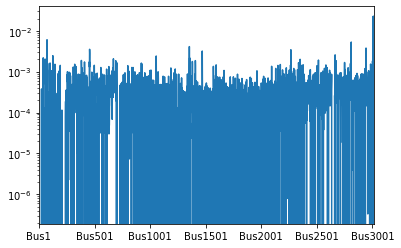

In [19]:
geo_load[i].plot(legend=False)
plt.yscale('log')
plt.show()

3. **Peak system load and temporal load profile.** For simplicity, assume $T=\left\{1,\ldots,24\right\}$. Let
$D_1, \ldots ,D_{24}$ denote the system-wide load during each hour of operation, and let $\gamma_t=\frac{D_{t+1}}{D_t}$ for $t= 1,\ldots , 23$, be the hourly variation in system load. In order to generate realistic distribution for these parameters, we analyzed hourly demand data from [PJM (2018)](https://www.pjm.com/markets-and-operations/energy.aspx). More specifically, we computed the mean $\mu_t$ and variance
$\sigma^2_t$ of each parameter $\gamma_t$, for $t= 1,\ldots ,23$.

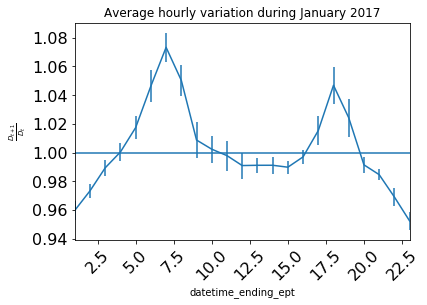

In [20]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
hrl = pd.read_csv('hrl_load_estimated.csv',infer_datetime_format=True, parse_dates=['datetime_beginning_utc', 
                                                                                    'datetime_beginning_ept',
                                                                                    'datetime_ending_utc', 
                                                                                    'datetime_ending_ept',])
gamma = hrl.groupby(['load_area',hrl['datetime_ending_ept'].dt.hour]).mean().unstack(0).pct_change() + 1
hourly_variation = gamma.mean(axis=1).dropna().to_frame('$\mu$')
hourly_variation['$\sigma$'] = gamma.std(axis=1).dropna()
hourly_variation['$\mu$'].plot(legend=False,
                               #xticks=hourly_variation.index,
                               kind="line",
                               rot=45,
                               fontsize=16,
                               yerr=hourly_variation['$\sigma$'])
plt.ylabel(r'$\frac{D_{t+1}}{D_t}$')
plt.title(r'Average hourly variation during January 2017')
plt.axhline(y=1)


 To generate instance variations, random numbers
 ${\gamma'}_t$ were then independently drawn from the Gaussian distribution $N(\mu_t, \sigma^2_t)$. Note that the
 $\gamma'$ parameters only specify the variation in system load from hour to hour, and are not sufficient to determine
 $D_1,\ldots ,D_{24}$. Therefore, in addition to these parameters, a random number $\rho$, corresponding to the peak system load $\max\{D_1,\ldots D_{24}\}$, was also generated. In the original instances, the peak system load is always $60\%$ of the total capacity. Based on our data analysis, we observed that the actual peak load rarely deviates more than $\pm 7.5\%$ from the day-ahead forecast. Therefore, to generate instance variations,$\rho$ was sampled from the uniform distribution in the interval $\left[0.6 \times 0.925C, 0.6\times 1.075C\right]$, where $C$ is the total capacity. Note that the $\rho$ and $\gamma'$ are now sufficient to construct $D_1,\ldots D_{24}$. Figure 1 shows a sample of some artificially generated load profiles.
 

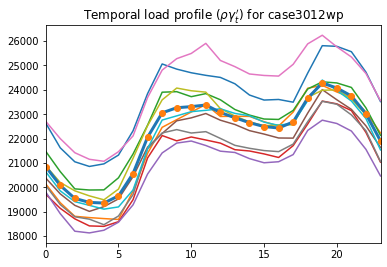

In [21]:
def get_peak_system_load( case,  capacity_pct=0.6, deviation=0.075 ):
    capacity = case.gen['PMAX'].sum()
    rho = np.random.uniform( low = capacity_pct*(1-deviation)*capacity, 
                            high = capacity_pct*(1+deviation)*capacity
                            )
    return rho
def get_hourly_load( case, hourly_variation_mean, hourly_variation_std ):
    gamma = np.random.normal(loc= hourly_variation_mean,
                            scale= hourly_variation_std)
    return gamma

def get_temporal_load_profile( case, gamma_prime, rho ):
    system_wide_load = [rho] + [0 for i in range(23)]
    t = 0
    for g_t in gamma_prime:
        system_wide_load[t+1] = system_wide_load[t]*g_t
        t += 1
    return system_wide_load

system_wide_load = pd.DataFrame()
for i in range(10):
    rho = get_peak_system_load( matpower[case] )
    gamma = get_hourly_load( matpower[case], hourly_variation[r'$\mu$'], hourly_variation[r'$\sigma$'] )
    system_wide_load[i] = get_temporal_load_profile( matpower[case], gamma, rho)
system_wide_load.plot(legend=False)
system_wide_load.mean(axis=1).plot(linewidth=3)
system_wide_load.mean(axis=1).plot(style='o')
plt.title(r"Temporal load profile ($\rho\gamma_t'$) for {}".format(matpower[case].name))
plt.savefig('duck-plots.png')
plt.show()

In [22]:
def get_bus_loads( case, gamma, rho, T=24 ):
    
    geo_load = get_geographical_load_distribution( case )
    bus_load = pd.DataFrame(columns=geo_load.columns, index=[t for t in range(T)])
    for t, gamma_t in enumerate(get_temporal_load_profile( case, gamma, rho)):
        bus_load.loc[t] = geo_load.loc[0]*gamma_t
    return bus_load

rho = get_peak_system_load( matpower[case] )
gamma = get_hourly_load( matpower[case], hourly_variation[r'$\mu$'], hourly_variation[r'$\sigma$'] )
bus_load = get_bus_loads( matpower[case], gamma, rho )
bus_load.to_csv('{}_instance_{}.csv'.format(case, 0))
bus_load



Bus1 Bus2 Bus3 Bus4 Bus5 Bus6 Bus7 Bus8 Bus9 Bus10 Bus11 Bus12 Bus13 Bus14  \
0     0    0    0    0    0    0    0    0    0     0     0     0     0     0   
1     0    0    0    0    0    0    0    0    0     0     0     0     0     0   
2     0    0    0    0    0    0    0    0    0     0     0     0     0     0   
3     0    0    0    0    0    0    0    0    0     0     0     0     0     0   
4     0    0    0    0    0    0    0    0    0     0     0     0     0     0   
5     0    0    0    0    0    0    0    0    0     0     0     0     0     0   
6     0    0    0    0    0    0    0    0    0     0     0     0     0     0   
7     0    0    0    0    0    0    0    0    0     0     0     0     0     0   
8     0    0    0    0    0    0    0    0    0     0     0     0     0     0   
9     0    0    0    0    0    0    0    0    0     0     0     0     0     0   
10    0    0    0    0    0    0    0    0    0     0     0     0     0     0   
11    0    0    0    0    0    0    0    0    0     0     0     0     0     0   
12    0    0    0    0    0    0    0    0    0     0     0     0     0     0   
13    0    0    0    0    0    0    0    0    0     0     0     0     0     0   
14    0    0    0    0    0    0    0    0    0     0     0     0     0     0   
15    0    0    0    0    0    0    0    0    0     0     0     0     0     0   
16    0    0    0    0    0    0    0    0    0     0     0     0     0     0   
17    0    0    0    0    0    0    0    0    0     0     0     0     0     0   
18    0    0    0    0    0    0    0    0    0     0     0     0     0     0   
19    0    0    0    0    0    0    0    0    0     0     0     0     0     0   
20    0    0    0    0    0    0    0    0    0     0     0     0     0     0   
21    0    0    0    0    0    0    0    0    0     0     0     0     0     0   
22    0    0    0    0    0    0    0    0    0     0     0     0     0     0   
23    0    0    0    0    0    0    0    0    0     0     0     0     0     0   

   Bus15 Bus16 Bus17 Bus18 Bus19 Bus20 Bus21 Bus22 Bus23    Bus24    Bus25  \
0      0     0     0     0     0     0     0     0     0  9.10992  8.59414   
1      0     0     0     0     0     0     0     0     0  8.69694  8.20454   
2      0     0     0     0     0     0     0     0     0  8.53837  8.05495   
3      0     0     0     0     0     0     0     0     0  8.54801  8.06405   
4      0     0     0     0     0     0     0     0     0  8.40906  7.93296   
5      0     0     0     0     0     0     0     0     0  8.60528  8.11807   
6      0     0     0     0     0     0     0     0     0  9.07908  8.56505   
7      0     0     0     0     0     0     0     0     0  9.76639  9.21344   
8      0     0     0     0     0     0     0     0     0  10.2161   9.6377   
9      0     0     0     0     0     0     0     0     0  10.2812  9.69914   
10     0     0     0     0     0     0     0     0     0  10.2932   9.7104   
11     0     0     0     0     0     0     0     0     0  10.4169  9.82716   
12     0     0     0     0     0     0     0     0     0  10.2961  9.71315   
13     0     0     0     0     0     0     0     0     0  10.2085  9.63052   
14     0     0     0     0     0     0     0     0     0  10.1176  9.54478   
15     0     0     0     0     0     0     0     0     0  10.0534  9.48423   
16     0     0     0     0     0     0     0     0     0  10.0812  9.51038   
17     0     0     0     0     0     0     0     0     0  10.3137   9.7298   
18     0     0     0     0     0     0     0     0     0  10.8137  10.2014   
19     0     0     0     0     0     0     0     0     0   11.102  10.4735   
20     0     0     0     0     0     0     0     0     0  10.9605  10.3399   
21     0     0     0     0     0     0     0     0     0  10.7621  10.1527   
22     0     0     0     0     0     0     0     0     0  10.3813  9.79357   
23     0     0     0     0     0     0     0     0     0  10.0028   9.4365   

   Bus26 Bus27 Bus28 Bus29

# Generated loads and costs for all Xavier cases

In [23]:
for case in cases:
    os.makedirs(case,exist_ok=True)
    matpower[case] =  set_pmin_to_zero( read_matpower('matpower/data/{}.m'.format(case)) )
    print(case)
    #display(matpower[case].load)
    for i in range(300):
        generator_cost = get_production_and_startup_costs( matpower[case] )
        rho = get_peak_system_load( matpower[case] )
        gamma = get_hourly_load( matpower[case], hourly_variation[r'$\mu$'], hourly_variation[r'$\sigma$'] )
        bus_load = get_bus_loads( matpower[case], gamma, rho )
        bus_load.to_csv('{}/{}_load_{:03d}.csv'.format(case, case, i))
        generator_cost.to_csv('{}/{}_gencost_{:03d}.csv'.format(case, case, i))

    

case1888rte
case1951rte
case2848rte
case3012wp
case3375wp
case6468rte
case6470rte
case6495rte
case6515rte


During test, 50 additional variations of each original instance were generated, using the same randomization scheme outline above, but with a different random seed. These instances were then solved to optimality using four different strategies: without any machine-learning $\bf\tt{(zero)}$, using only the transmission oracle $\tt{(tr)}$, using transmission and warm-start oracles $\tt{(tr-ws)}$ and finally using only the transmission and affine subspace detection oracles $\tt{(tr-aff)}$. For strategies $\tt{zero}$, $\tt{tr}$ and $\tt{tr-ws}$, CPLEX was configured to use a relative MIP gap tolerance of $0.1\%$. For strategy $\tt{tr-aff}$, this tolerance was reduced to $0.05\%$, to compensate for eventual inaccurate predictions.

In [ ]:
branches = {}
line_power = {}
for case in cases:
    print('case {}:\n\tBuses: {}\n\tUnits: {}\n\tLines: {}\n'.format(case, len(matpower[case].bus_name), len(matpower[case].gen_name), 
                                                                   len(matpower[case].branch_name)))
    branches[case] = matpower[case].branch.copy()
    matpower[case].branch['RATE_A'] = 0
    scuc[case] = build_model( matpower[case])
    scuc[case].solve(verbose=True, solver='scip')
    line_power[case] = scuc[case].results.line_power
    display(line_power[case])


case case1888rte:
	Buses: 1888
	Units: 298
	Lines: 2531



/Users/zuck016/Projects/Proposals/DataModelConvergence_2019/PSST/psst/psst/model/__init__.py:85: UserWarning: Generators with zero PMAX found: ['GenCo32']
  warnings.warn("Generators with zero PMAX found: {}".format(zero_generation))


Changed model.MinimumPowerOutput to use within=Reals
SCIP version 6.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 4.0.2] [GitHash: e639a0059d]
Copyright (C) 2002-2019 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline EditLine w  GNU library for command line editing (gnu.org/s/readline)
  SoPlex 4.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: b8833cd3]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.3.8          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  ASL                  AMPL Solver Library developed by D. Gay (www.netlib.com/ampl)


number of paramet

    containing a solution


0      1           2           3     4          5           6     7     \
0   5.8  670.0 -507.134812 -162.865188   0.0 -68.073628  210.573628 -14.7   

        8           9          10         11         12    13    14    \
0 -34.573551  173.623067 -79.594421  33.467953  15.305598 -42.6  18.6   

       15    16          17          18         19    20          21     22    \
0  3.471354   0.0 -572.929757  681.788147 -79.551385   0.0  681.192996  390.4   

   23    24          25         26    27        28         29          30    \
0   5.8  -5.8  108.701244  40.098756  25.6 -1.059774  40.159774  303.376003   

         31       32        33    34    35        36          37    \
0 -232.876003  4.85135  31.14865   3.5   3.5 -31.14865  173.978407   

         38         39         40    41    42    43         44        45    \
0 -119.129756 -89.237113  95.137113   6.9  34.0   9.2  62.336393  5.363607   

        46         47         48        49    50    51        52    \
0  78.322974 -75.052936  18.087366  4.042596  32.0  32.0  7.716371   

         53    54         55          56    57         58          59    60    \
0  101.383629 -37.5 -40.976975  101.360994 -65.4 -40.502842  100.647873 -50.1   

        61          62    63         64          65          66    67    \
0  100.37095 -260.933345  -4.8 -33.028567  159.669596  160.792317 -14.6   

         68          69          70        71         72        73    \
0 -343.091707  217.726852  208.864855 -71.41669  122.01669  61.90955   

       74         75         76          77         78         79    80    \
0 -44.90955 -44.578279 -43.581973  736.360252  62.618427  26.381573 -77.3   

   81          82          83          84          85         86    \
0 -83.6  117.521593 -343.033958 -254.021779  524.109154  96.325804   

         87          88          89          90         91    92    93    \
0 -346.475165 -254.033521  524.622734  106.187948  82.518782  64.6  13.4   

   94         95         96         97         98         99    100   101   \
0  33.3  83.255573  45.819494  82.524933  27.196429  64.903571  27.5 -57.5   

   102   103        104        105         106   107        108   109   \
0   0.0   0.0 -27.852593 -64.732973 -176.397623  -4.2  56.098024 -54.5   

         110        111        112    113    114   115   116   117   \
0 -161.467027 -60.869254  57.621445  250.0  250.0  10.4   0.0   0.0   

        118        119         120       121       122         123   \
0 -10.804824  79.504824 -150.101352 -7.216735  0.586693 -711.148206   

         124   125   126        127       128        129        130   \
0  969.079601  28.2  28.9  73.730596 -5.164879  41.034283  77.669375   

        131   132   133   134   135   136   137   138   139   140        141   \
0 -50.369375   0.0  36.5  36.8   0.0   8.4  13.2  22.7  13.2  11.4  18.772779   

       142        143   144         145        146         147   148   \
0 -8.572779 -77.363096 -36.6  146.775071 -90.862543 -169.400498 -22.9   

         149         150         151       152         153         154   \
0 -167.039748  183.088988  357.675612 -19.85768  409.414851  247.292017   

        155    156        157        158        159   160   161         162   \
0  74.705416 -108.9  52.331941  95.768059 -55.405416   0.0   0.0 -118.533345   

         163       164     165         166         167         168   \
0  250.433345 -259.0883  899.72 -708.801214 -523.623709 -708.801214   

         169     170     171       172         173   174   175   176   177   \
0 -519.885562  910.74  909.74  4.460919 -168.949219  -1.7   3.6  35.4  15.1   

   178        179         180   181   182         183         184        185   \
0  57.4 -88.111486  178.011486  -0.2  -0.3  308.587383  329.812617 -111.36103   

        186   187        188        189        190         191        192   \
0  146.86103 -36.3  55.887082  56.512918 -47.548571  137.851685 -83.103114   

   193   194         195         196     197       

case case1951rte:
	Buses: 1951
	Units: 392
	Lines: 2596



/Users/zuck016/Projects/Proposals/DataModelConvergence_2019/PSST/psst/psst/model/__init__.py:85: UserWarning: Generators with zero PMAX found: ['GenCo35']
  warnings.warn("Generators with zero PMAX found: {}".format(zero_generation))


Changed model.MinimumPowerOutput to use within=Reals
SCIP version 6.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 4.0.2] [GitHash: e639a0059d]
Copyright (C) 2002-2019 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline EditLine w  GNU library for command line editing (gnu.org/s/readline)
  SoPlex 4.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: b8833cd3]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.3.8          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  ASL                  AMPL Solver Library developed by D. Gay (www.netlib.com/ampl)


number of paramet

    containing a solution


0     1           2           3      4          5           6      7     \
0  36.4  -1.4 -502.311453 -196.788547  700.5 -17.530725  262.730725  108.9   

        8           9          10         11        12    13    14    \
0  69.775474 -162.586951  70.574916 -31.662277 -0.313197 -29.3  14.0   

        15     16          17          18         19     20          21    \
0  49.012035  184.0  412.205283  144.620432 -68.219903  184.0  144.494188   

   22    23    24         25          26    27          28          29    \
0  85.7  20.7 -20.7  56.870748  136.529252  57.7 -220.933461  248.733461   

         30        31        32         33    34    35         36    \
0  170.220804  7.279196 -2.513402  26.713402 -91.5 -91.5 -26.713402   

         37          38         39         40    41    42    43        44    \
0  217.770259 -124.856856 -17.038514  29.338514  29.2  67.9  77.8 -4.267283   

         45          46          47          48         49    50    51    \
0  109.867283  119.051246 -181.452736  124.114598 -20.613108  56.2  29.3   

         52         53    54         55          56     57         58    \
0  123.779018 -19.239018 -2.44 -58.562832  169.264062 -121.4 -57.885217   

         59    60          61          62    63         64          65    \
0  168.073213 -95.0  167.610774 -321.340411  -1.9 -77.251791  217.581137   

         66    67          68         69          70          71    72    \
0  219.111064 -26.8 -510.148738  339.93297  330.215769  133.214622  89.4   

         73         74         75          76          77         78    \
0 -133.214622 -19.944959  30.244959 -218.518715 -213.634916 -56.846369   

       79          80     81     82          83         84          85    \
0  0.304964  143.895036 -123.5 -135.5  249.429741 -70.599354  499.595643   

         86          87         88          89          90          91    \
0  560.096907 -611.087888 -71.307584  499.618737  560.645753 -648.665642   

         92    93    94    95          96         97          98         99    \
0 -523.496573  64.7  44.6  46.9  145.639313  91.299486  144.361201  49.677616   

         100   101   102   103   104    105        106        107        108   \
0  111.822384  49.0 -79.0   0.0   0.0 -78.65 -50.673033 -95.539837 -332.73161   

    109         110    111         112        113    114         115    116   \
0  143.0  271.645313 -116.5 -227.660163 -85.662896 -78.65  279.022226  250.0   

    117   118   119   120      121       122         123        124   \
0  245.9  10.0   0.0 -73.0  7.91116  66.68884 -264.650125  34.709345   

        125         126         127   128   129         130        131   \
0 -44.770784 -214.091204  649.002768  14.7  31.0  458.639172 -49.196294   

         132        133        134         135   136   137   138   139   140   \
0 -162.854277 -45.388601 -45.458774  102.458774  -6.0  55.7  55.4 -27.0  16.4   

    141   142   143   144        145        146         147   148        149   \
0 -122.4  54.7  29.7 -21.9  44.467323 -15.267323 -168.572816 -61.3  26.577946   

         150         151   152         153         154         155   \
0 -185.000973 -276.874292 -39.2 -273.015796 -375.803693  385.618969   

        156         157        158         159    160         161   \
0  111.33543  441.400329  562.98614  229.588814 -226.5  128.433241   

         162         163   164   165         166         167         168   \
0  174.366759 -200.588814 -38.4 -12.8 -160.940411  343.340411 -360.130422   

     169         170         171         172         173     174     175   \
0  899.72 -789.104769 -392.330443 -789.104769 -389.529598  910.74  909.74   

       176         177   178   179   180   181   182         183         184   \
0 -50.73923 -193.291192  -7.4  14.0  48.7   2.6  61.9 -133.405211  291.505211   

   185   186         187         188        189        190   191        192   \
0  -2.9  -1.4  188.855091  201.844909  93.045405  15.554595 -70.7  105.11147   


case case2848rte:
	Buses: 2848
	Units: 548
	Lines: 3776



/Users/zuck016/Projects/Proposals/DataModelConvergence_2019/PSST/psst/psst/model/__init__.py:85: UserWarning: Generators with zero PMAX found: ['GenCo191', 'GenCo192', 'GenCo314']
  warnings.warn("Generators with zero PMAX found: {}".format(zero_generation))


Changed model.MinimumPowerOutput to use within=Reals
SCIP version 6.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 4.0.2] [GitHash: e639a0059d]
Copyright (C) 2002-2019 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline EditLine w  GNU library for command line editing (gnu.org/s/readline)
  SoPlex 4.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: b8833cd3]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.3.8          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  ASL                  AMPL Solver Library developed by D. Gay (www.netlib.com/ampl)


number of paramet

    containing a solution


0     1      2           3           4     5          6        7     \
0  20.6  20.9  670.0 -522.427094 -147.572906   0.0 -31.288905  16.5963   

        8     9     10        11          12         13         14    \
0  14.692605   0.4  -2.3 -7.032418  117.532418 -12.171542  26.948165   

        15        16        17          18          19         20       21    \
0  29.923377 -2.641854 -1.361011  218.203209 -124.833577  27.453611  31.8074   

   22    23         24    25          26        27         28    29    \
0  -8.3 -26.2 -38.727779   0.0 -371.982834  209.6008  49.196388   0.0   

         30          31    32    33    34         35        36         37    \
0  209.417833  127.967813  13.9 -13.9  -4.1  17.824582 -8.824582  97.580979   

        38    39          40          41    42         43         44    \
0  22.419021  35.0 -111.345484  156.345484   0.0  95.557767 -18.257767   

        45         46    47        48         49    50        51         52    \
0  23.807831  24.592169  -9.6  1.599159  12.600841  -7.1  3.912183  10.861527   

       53    54    55         56         57         58         59    \
0  25.62629   3.5   3.5 -24.592169  68.726934 -26.134765 -17.570506   

        60    61    62    63         64       65         66    67    68    \
0  18.570506  22.0  -2.1  39.1 -18.918558 -3.83527  29.853828   3.5   7.7   

   69    70    71    72    73    74         75    76         77    78    \
0  18.4   0.0  -6.3   0.0   2.4   0.0  23.281399  -8.6  11.318601   0.7   

        79        80        81         82         83        84         85    \
0  15.952936 -6.652936 -4.479591  82.879591  85.744632 -71.60632  26.714285   

        86    87    88         89         90    91        92         93    \
0 -15.752598  40.2  40.2 -16.781221 -32.152568   0.0 -4.555974  25.025988   

   94         95         96         97         98        99         100   \
0 -24.4  79.180132  34.628128 -23.144485  25.137274  3.862726 -38.455078   

         101   102        103        104   105        106   107   108   109   \
0  100.316941 -72.2 -38.010125  99.611166 -53.2  99.337095  19.0 -16.7  19.0   

       110       111       112   113       114        115        116   \
0  6.073176 -6.373176 -20.40372   0.0 -16.71745 -22.545335 -12.946331   

        117         118   119        120        121         122   123   \
0 -13.390873 -255.136622  -6.7 -10.456384  188.93411  190.262605 -19.6   

         124         125         126        127   128        129   130   \
0 -369.702895  234.310881  221.592014  79.204972  53.9 -79.204972  -9.0   

        131       132        133       134       135         136        137   \
0 -14.198376  17.69952  13.398856  0.346161  0.338425  801.815414 -80.624249   

         138   139   140        141         142         143       144   \
0  160.824249  -8.4 -19.3  60.673066  372.635869  393.074456  35.97335   

         145         146         147        148         149         150   \
0 -529.766579  376.374032  393.092626  36.008601 -564.660763 -453.831591   

   151   152       153        154       155        156   157       158   159   \
0   5.5   0.6  2.071434  18.620798  8.507768 -18.620798  39.6 -0.833131   0.0   

        160   161   162        163        164        165        166   \
0  13.333131   0.4  42.5  53.406753  37.155184  52.938062  29.845605   

        167   168   169   170   171        172        173         174   175   \
0  53.854395   2.5  -2.5   0.0   0.0 -30.646818 -78.529206 -198.666584  -4.2   

        176   177         178       179         180    181    182   183   \
0  99.977639 -76.0 -188.370794 -63.05691  102.692673  250.0  268.0  15.2   

   184   185   186   187        188   189       190        191       192   \
0   0.0  0.02  5.68   7.8  40.116947   0.0 -3.986301  39.569353  5.432621   

       193   194   195      196       197        198        199         200   \
0  1.667379   0.0   0.0  7.79281  51.80719  43.990037 -16.190037 -101.978968   

     

case case3012wp:
	Buses: 3012
	Units: 502
	Lines: 3572



/Users/zuck016/Projects/Proposals/DataModelConvergence_2019/PSST/psst/psst/model/__init__.py:85: UserWarning: Generators with zero PMAX found: ['GenCo496', 'GenCo497', 'GenCo498', 'GenCo499', 'GenCo500', 'GenCo501']
  warnings.warn("Generators with zero PMAX found: {}".format(zero_generation))


Changed model.MinimumPowerOutput to use within=Reals
**WARNING: Piecewise component 'ComputeProductionCosts[('GenCo85', 0)]' has detected slopes of consecutive piecewise segments to be within 1e-20 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
**WARNING: Piecewise component 'ComputeProductionCosts[('GenCo86', 0)]' has detected slopes of consecutive piecewise segments to be within 1e-20 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
**WARNING: Piecewise component 'ComputeProductionCosts[('GenCo87', 0)]' has detected slopes of consecutive piecewise segments to be within 1e-20 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
**WARNING: Piecewise component 'ComputeProductionCosts[('GenCo88', 0)]' has detected slopes of consecutive piecewise segments to be within 1e-20 of one another. Refer to the Piecewise help docum

## Run 3 instances of the last case

In [17]:
for i in range(3):
    generator_cost = pd.read_csv('{}/{}_gencost_{:03d}.csv'.format(case, case, i),index_col=0)
    matpower[case].gencost = generator_cost
    bus_load = pd.read_csv('{}/{}_load_{:03d}.csv'.format(case, case,i),index_col=0)
    matpower[case].load = bus_load
    scuc[case,i] = build_model(matpower[case])
    scuc[case,i].solve(verbose=True, solver='scip')

Changed model.MinimumPowerOutput to use within=Reals


ERROR:pyomo.core:Constructing component 'PowerBalance' from data=None failed:
KeyboardInterrupt: 


ERROR: Constructing component 'PowerBalance' from data=None failed:
    KeyboardInterrupt:


KeyboardInterrupt: 

In [15]:
dir(scuc[case].results)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_get',
 '_maximum_hours',
 '_model',
 'angles',
 'commitment_cost',
 'expected_profit',
 'line_power',
 'lmp',
 'maximum_line_power',
 'maximum_power_available',
 'maximum_power_output',
 'model',
 'noload_cost',
 'power_generated',
 'production_cost',
 'regulating_reserve_up_available',
 'unit_commitment']

In [21]:
scuc[case].results.power_generated

GenCo1364 GenCo12 GenCo1029 GenCo1017 GenCo1217 GenCo239 GenCo594 GenCo188  \
0      None    None      None      None      None     None     None     None   

  GenCo723 GenCo675 GenCo775 GenCo794 GenCo1013 GenCo990 GenCo1351 GenCo1061  \
0     None     None     None     None      None     None      None      None   

  GenCo387 GenCo153 GenCo516 GenCo935 GenCo1181 GenCo807 GenCo63 GenCo757  \
0     None     None     None     None      None     None    None     None   

  GenCo1051 GenCo507 GenCo1184 GenCo1282 GenCo759 GenCo1064 GenCo717 GenCo172  \
0      None     None      None      None     None      None     None     None   

  GenCo1355 GenCo985 GenCo88 GenCo965 GenCo854 GenCo80 GenCo443 GenCo158  \
0      None     None    None     None     None    None     None     None   

  GenCo427 GenCo1162 GenCo432 GenCo725 GenCo604 GenCo1063 GenCo859 GenCo51  \
0     None      None     None     None     None      None     None    None   

  GenCo165 GenCo44 GenCo455 GenCo730 GenCo1307 GenCo828 GenCo915 GenCo957  \
0     None    None     None     None      None     None     None     None   

  GenCo342 GenCo122 GenCo816 GenCo798 GenCo297 GenCo584 GenCo812 GenCo861  \
0     None     None     None     None     None     None     None     None   

  GenCo864 GenCo1206 GenCo377 GenCo899 GenCo1196 GenCo365 GenCo917 GenCo831  \
0     None      None     None     None      None     None     None     None   

  GenCo127 GenCo677 GenCo781 GenCo10 GenCo938 GenCo1043 GenCo729 GenCo1233  \
0     None     None     None    None     None      None     None      None   

  GenCo1032 GenCo1325 GenCo607 GenCo309 GenCo626 GenCo1366 GenCo692 GenCo805  \
0      None      None     None     None     None      None     None     None   

  GenCo255 GenCo657 GenCo943 GenCo783 GenCo364 GenCo524 GenCo777 GenCo1288  \
0     None     None     None     None     None     None     None      None   

  GenCo872 GenCo747 GenCo1133 GenCo1138 GenCo446 GenCo755 GenCo874 GenCo810  \
0     None     None      None      None     None     None     None     None   

  GenCo696 GenCo209 GenCo1123 GenCo1374 GenCo849 GenCo1240 GenCo930 GenCo65  \
0     None     None      None      None     None      None     None    None   

  GenCo29 GenCo233 GenCo585 GenCo82 GenCo855 GenCo501 GenCo889 GenCo901  \
0    None     None     None    None     None     None     None     None   

  GenCo143 GenCo474 GenCo966 GenCo1091 GenCo243 GenCo1114 GenCo947 GenCo155  \
0     None     None     None      None     None      None     None     None   

  GenCo189 GenCo199 GenCo1350 GenCo1215 GenCo771 GenCo129 GenCo1295 GenCo765  \
0     None     None      None      None     None     None      None     None   

  GenCo1112 GenCo716 GenCo465 GenCo857 GenCo565 GenCo263 GenCo1048 GenCo156  \
0      None     None     None     None     None     None      None     None   

  GenCo171 GenCo503 GenCo157 GenCo672 GenCo1124 GenCo615 GenCo643 GenCo1175  \
0     None     None     None     None      None     None     None      None   

  GenCo137 GenCo222 GenCo749 GenCo1045 GenCo851 GenCo1208 GenCo645 GenCo272  \
0     None     None     None      None     None      None     None     None   

  GenCo41 GenCo1348 GenCo885 GenCo208 GenCo388 GenCo740 GenCo773 GenCo123  \
0    None      None     None     None     None     None     None     None   

  GenCo525 GenCo340 GenCo375 GenCo207 GenCo346 GenCo314 GenCo46 GenCo1229  \
0     None     None     None     None     None     None    None      None   

  GenCo502 GenCo490 GenCo333 GenCo1094 GenCo1121 GenCo494 GenCo694 GenCo719  \
0     None     None     None      None      None     None     None     None   

  GenCo386 GenCo880 GenCo510 GenCo1171 GenCo1376 GenCo535 GenCo519 GenCo1363  \
0     None     None     None      None      None     None     None      None   

  GenCo656 GenCo726 GenCo648 GenCo369 GenCo778 GenCo829 GenCo1146 GenCo1191  \
0     None     None     None     None     None     None      None      None   

  GenCo758 GenCo618 GenCo1256 GenCo684 GenCo589 GenCo

In [29]:
scuc[case].results.production_cost

TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

In [28]:
uc = scuc[case].results.unit_commitment
scuc[case].results.noload_cost

32646.299999999996

In [27]:
scuc[case].results.maximum_line_power

0         0
1         0
2         0
3         0
4         0
       ... 
9032    326
9033    287
9034      0
9035      0
9036      0
Length: 9037, dtype: int64

In [18]:
scuc[case].results.maximum_power_available

GenCo1364 GenCo12 GenCo1029 GenCo1017 GenCo1217 GenCo239 GenCo594 GenCo188  \
0      None    None      None      None      None     None     None     None   

  GenCo723 GenCo675 GenCo775 GenCo794 GenCo1013 GenCo990 GenCo1351 GenCo1061  \
0     None     None     None     None      None     None      None      None   

  GenCo387 GenCo153 GenCo516 GenCo935 GenCo1181 GenCo807 GenCo63 GenCo757  \
0     None     None     None     None      None     None    None     None   

  GenCo1051 GenCo507 GenCo1184 GenCo1282 GenCo759 GenCo1064 GenCo717 GenCo172  \
0      None     None      None      None     None      None     None     None   

  GenCo1355 GenCo985 GenCo88 GenCo965 GenCo854 GenCo80 GenCo443 GenCo158  \
0      None     None    None     None     None    None     None     None   

  GenCo427 GenCo1162 GenCo432 GenCo725 GenCo604 GenCo1063 GenCo859 GenCo51  \
0     None      None     None     None     None      None     None    None   

  GenCo165 GenCo44 GenCo455 GenCo730 GenCo1307 GenCo828 GenCo915 GenCo957  \
0     None    None     None     None      None     None     None     None   

  GenCo342 GenCo122 GenCo816 GenCo798 GenCo297 GenCo584 GenCo812 GenCo861  \
0     None     None     None     None     None     None     None     None   

  GenCo864 GenCo1206 GenCo377 GenCo899 GenCo1196 GenCo365 GenCo917 GenCo831  \
0     None      None     None     None      None     None     None     None   

  GenCo127 GenCo677 GenCo781 GenCo10 GenCo938 GenCo1043 GenCo729 GenCo1233  \
0     None     None     None    None     None      None     None      None   

  GenCo1032 GenCo1325 GenCo607 GenCo309 GenCo626 GenCo1366 GenCo692 GenCo805  \
0      None      None     None     None     None      None     None     None   

  GenCo255 GenCo657 GenCo943 GenCo783 GenCo364 GenCo524 GenCo777 GenCo1288  \
0     None     None     None     None     None     None     None      None   

  GenCo872 GenCo747 GenCo1133 GenCo1138 GenCo446 GenCo755 GenCo874 GenCo810  \
0     None     None      None      None     None     None     None     None   

  GenCo696 GenCo209 GenCo1123 GenCo1374 GenCo849 GenCo1240 GenCo930 GenCo65  \
0     None     None      None      None     None      None     None    None   

  GenCo29 GenCo233 GenCo585 GenCo82 GenCo855 GenCo501 GenCo889 GenCo901  \
0    None     None     None    None     None     None     None     None   

  GenCo143 GenCo474 GenCo966 GenCo1091 GenCo243 GenCo1114 GenCo947 GenCo155  \
0     None     None     None      None     None      None     None     None   

  GenCo189 GenCo199 GenCo1350 GenCo1215 GenCo771 GenCo129 GenCo1295 GenCo765  \
0     None     None      None      None     None     None      None     None   

  GenCo1112 GenCo716 GenCo465 GenCo857 GenCo565 GenCo263 GenCo1048 GenCo156  \
0      None     None     None     None     None     None      None     None   

  GenCo171 GenCo503 GenCo157 GenCo672 GenCo1124 GenCo615 GenCo643 GenCo1175  \
0     None     None     None     None      None     None     None      None   

  GenCo137 GenCo222 GenCo749 GenCo1045 GenCo851 GenCo1208 GenCo645 GenCo272  \
0     None     None     None      None     None      None     None     None   

  GenCo41 GenCo1348 GenCo885 GenCo208 GenCo388 GenCo740 GenCo773 GenCo123  \
0    None      None     None     None     None     None     None     None   

  GenCo525 GenCo340 GenCo375 GenCo207 GenCo346 GenCo314 GenCo46 GenCo1229  \
0     None     None     None     None     None     None    None      None   

  GenCo502 GenCo490 GenCo333 GenCo1094 GenCo1121 GenCo494 GenCo694 GenCo719  \
0     None     None     None      None      None     None     None     None   

  GenCo386 GenCo880 GenCo510 GenCo1171 GenCo1376 GenCo535 GenCo519 GenCo1363  \
0     None     None     None      None      None     None     None      None   

  GenCo656 GenCo726 GenCo648 GenCo369 GenCo778 GenCo829 GenCo1146 GenCo1191  \
0     None     None     None     None     None     None      None      None   

  GenCo758 GenCo618 GenCo1256 GenCo684 GenCo589 GenCo

In [20]:
scuc[case].results.model

<psst.model.PSSTModel(status=solved)>

In [19]:
scuc[case].results.maximum_power_output

KeyError: "Index 'GenCo0' is not valid for indexed component 'MaximumPowerOutput'"

## Reproduce negative PMIN problem

In [9]:
!git clone https://github.com/MATPOWER/matpower.git

fatal: destination path 'matpower' already exists and is not an empty directory.


In [40]:

import psst
from psst.case import read_matpower
from psst.model import build_model

case = read_matpower('matpower/data/case1888rte.m')
print(case.gen.loc['GenCo32', 'PMIN'])
try:
    model = build_model(case)
except ValueError as e:
    print(e)

-8.0
Changed model.MinimumPowerOutput to use within=Reals


ERROR:pyomo.core:Constructing component 'ComputeProductionCosts' from data=None failed:
ValueError: 'ComputeProductionCosts[GenCo32,0]' does not have a list of domain points that is non-decreasing


ERROR: Constructing component 'ComputeProductionCosts' from data=None failed:
    ValueError: 'ComputeProductionCosts[GenCo32,0]' does not have a list of
    domain points that is non-decreasing
'ComputeProductionCosts[GenCo32,0]' does not have a list of domain points that is non-decreasing


In [5]:
dir(matpower[case])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_attributes',
 '_filename',
 '_read_festiv',
 '_read_matpower',
 'baseMVA',
 'branch',
 'branch_name',
 'bus',
 'bus_name',
 'gen',
 'gen_name',
 'gen_status',
 'gencost',
 'load',
 'name',
 'period',
 'version']

In [50]:
case = 'case3012wp'
scuc[case] = read_matpower('matpower/data/{}.m'.format(case))
table = '|Instance|Buses|Units|Lines|\n|----|----|----|---|\n'

table += '|{}|{}|{}|{}|\n'.format(case, len(scuc[case].bus_name),
                                             len(scuc[case].gen_name),
                                             len(scuc[case].branch_name))
#case_network = create_network(case)
#case_network
Markdown(table)

|Instance|Buses|Units|Lines|
|----|----|----|---|
|case3012wp|3012|502|3572|


In [37]:
case.bus


TYPE     PD    QD  GS  BS  AREA        VM         VA  BASEKV  ZONE  \
Bus1        1    5.8  -5.8   0   0     1  1.031493 -43.492413     225     1   
Bus2        1    0.0   0.0   0   0     1  1.052035  -1.699896     380     1   
Bus3        1  142.5 -13.4   0   0     1  1.044838 -18.267388     225     1   
Bus4        1    0.0   0.0   0   0     1  1.064605 -20.592316     150     1   
Bus5        1   32.8  -5.3   0   0     1  1.061605 -24.974129     225     1   
...       ...    ...   ...  ..  ..   ...       ...        ...     ...   ...   
Bus1822     1  330.0 -90.0   0   0     1  1.101104 -36.284610     380     1   
Bus1823     1  137.7 -21.3   0   0     1  1.042640 -27.908000     225     1   
Bus1824     1  137.5 -21.2   0   0     1  1.042636 -27.907674     225     1   
Bus1825     1  356.3 -41.8   0   0     1  1.048838 -26.553688     380     1   
Bus1826     1  398.1 -58.5   0   0     1  1.070825 -18.671574     380     1   

            VMAX      VMIN  
Bus1     1.08889  0.888889  
Bus2     1.10263  1.048410  
Bus3     1.08444  1.004440  
Bus4     1.10667  0.900000  
Bus5     1.08889  0.933333  
...          ...       ...  
Bus1822  1.10526  1.039470  
Bus1823  1.08889  0.933333  
Bus1824  1.08889  0.933333  
Bus1825  1.10526  1.039470  
Bus1826  1.10526  1.050700  

[1888 rows x 12 columns]